# Summary

## Annotation differences

- GTEx analyses was perfomed using __Ensembl GRCh38__ while nascent pairs were generated using __RefSeq hg38 p14 (Release GCF_000001405.40-RS_2023_03)__ annotations.

- These differences result is a non-overlapping set of genes (from a quick look, most of the genes are lncRNAs). 

- This means, the denominator for recovered pairs should be based on regions from genes with overlaps.

# Load libraries

In [1]:
library(data.table) ## load files into R faster
library(ggplot2)    ##plotting package
library(dplyr)      ## data structure wrangling
library(cowplot)    ##plots + arrange plots etc
library(parallel)   ##parallel processing


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

In [2]:
map_overlaps <- function(overlap_DT, egene_ids, nascent_pairs){
    
    #1: merge the GTEx overlaps with gene ids
    overlap_bed_DT_genename <- merge(overlap_DT, 
                                     egene_ids,
                                     by='gene_id')
    
    #2: merge the overlap bed file with the nascent pairs
    overlap_bed_DT_genename_bidirs <- merge(overlap_bed_DT_genename,
                                            nascent_pairs,
                                            by.x = 'bidir_id',
                                            by.y = 'transcript_2',
                                            all = TRUE, 
                                            allow.cartesian=TRUE) ##for duplicate keys

    #3: get overlapping bidirectionals and match gene pairs
    overlap_bed_DT_nascent_gtex <- subset(overlap_bed_DT_genename_bidirs,
                                          gene_name==nascent_gene_id)
    
    #4: summarize overlaps
    overlaps <- list(length(unique(overlap_bed_DT_nascent_gtex$variant_id)),
                    length(unique(overlap_bed_DT_nascent_gtex$pair_id)))

    names(overlaps) <- c("eqtl_overlap","nascent_pair_overlap")
    return(overlaps)
    
}

In [3]:
shuffle_genes <- function(pairs_DT, seed=42){
    ##shuffle genes within a chromosome pairs
    
    #set a seed
    set.seed(seed)
    
    #reassign the pairs to a new variable
    pairs_DT_shuffled_genes <- pairs_DT
    
    #shuffle the genes
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    
    #relabel the gene names
    pairs_DT_shuffled_genes$nascent_gene_id <- as.character(lapply(strsplit(pairs_DT_shuffled_genes$transcript_1, ':'),
                                                      `[`, 1))
    return(pairs_DT_shuffled_genes)
   
}

In [4]:
#https://rdrr.io/github/ghurault/HuraultMisc/src/R/pval.R

empirical_pval <- function(t_rep, t, alternative = c("two.sided", "less", "greater")) {
    
    #default will be set to "two.sided" if none are supplied
    alternative <- match.arg(alternative)
    
    #variables for p-value calulcations
    #number of permutations greater than observed
    r <- sum(t_rep > t)
    
    #total number of permutations
    n <- length(t_rep)
    
    #empirical p-value where r is the number of permutation tests with
    #a “more extreme” observed test statistic  Tithan  T0
    p <- (r + 1) / (n + 1) # instead of r/n, since the r replicates and the data are assumed from the null
    
    if (alternative == "greater") {
        
        pval <- p
        
    } else if (alternative == "less") {
        
        pval <- 1 - p
        
    } else if (alternative == "two.sided") {
        
        pval <- 2 * min(p, 1 - p)
    }
    
    return(pval)
}

# Import data

## GTEx pairs

### Whole blood significant


    - variant_id:               variant ID in the format {chr}_{pos_first_ref_base}_{ref_seq}_{alt_seq}_b38
    - gene_id:                  GENCODE/Ensembl gene ID
    - tss_distance:             distance between variant and transcription start site.
                                Positive when variant is downstream of the TSS, negative otherwise
    - ma_samples:               number of samples carrying the minor allele
    - ma_count:                 total number of minor alleles across individuals
    - maf:                      minor allele frequency observed in the set of donors for a given tissue
    - pval_nominal:             nominal p-value
    - slope:                    regression slope
    - slope_se:                 standard error of the regression slope
    - pval_nominal_threshold:   nominal p-value threshold for calling variant-gene pair significant for the gene
    - min_pval_nominal:         smallest nominal p-value for the gene
    - pval_beta:                beta-approximated permutation p-value for the gene


In [5]:
gtex_blood <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/Whole_Blood.v8.signif_variant_gene_pairs.txt.gz")
dim(gtex_blood)
head(gtex_blood)

[1] 2414653      12

variant_id          gene_id           tss_distance ma_samples ma_count
1 chr1_64764_C_T_b38  ENSG00000227232.5   35211       79         80     
2 chr1_665098_G_A_b38 ENSG00000227232.5  635545      140        146     
3 chr1_666028_G_A_b38 ENSG00000227232.5  636475      125        131     
4 chr1_17556_C_T_b38  ENSG00000238009.6 -111667       27         27     
5 chr1_58814_G_A_b38  ENSG00000238009.6  -70409      109        119     
6 chr1_60351_A_G_b38  ENSG00000238009.6  -68872       83         92     
  maf       pval_nominal slope    slope_se  pval_nominal_threshold
1 0.0597015 1.72756e-09  0.516614 0.0844652 0.000393213           
2 0.1089550 8.84898e-13  0.462697 0.0633368 0.000393213           
3 0.0977612 3.85133e-13  0.489662 0.0659359 0.000393213           
4 0.0201493 1.48531e-06  0.760661 0.1564470 0.000333231           
5 0.0888060 1.49434e-18  0.636831 0.0700984 0.000333231           
6 0.0686567 6.43685e-13  0.575975 0.0783446 0.000333231           
  min_pval_nominal pval_beta  
1 3.85133e-13      1.05258e-09
2 3.85133e-13      1.05258e-09
3 3.85133e-13      1.05258e-09
4 4.99434e-31      1.05973e-25
5 4.99434e-31      1.05973e-25
6 4.99434e-31      1.05973e-25

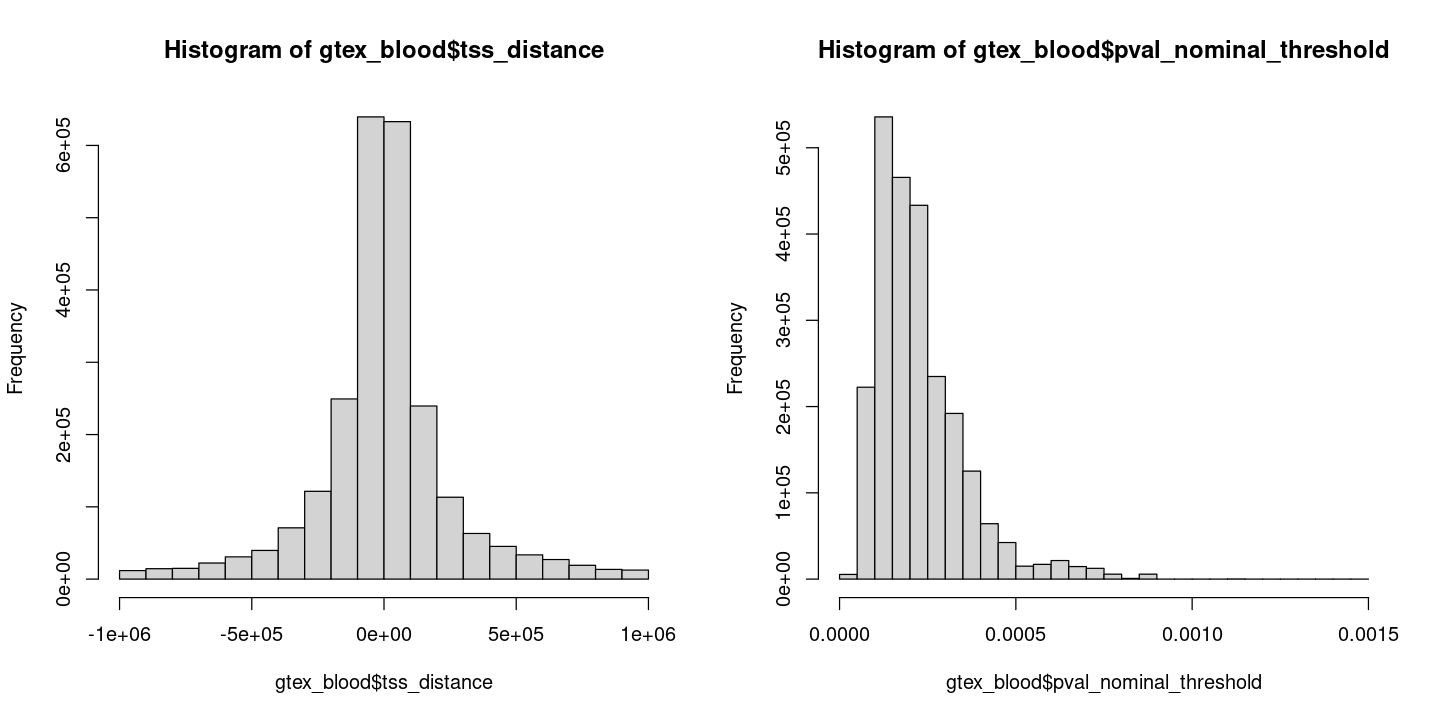

In [6]:
options(repr.plot.width=12, repr.plot.height=6)

par(mfrow = c(1, 2))

##distance distribution
hist(gtex_blood$tss_distance)

##p-value distribution
hist(gtex_blood$pval_nominal_threshold)

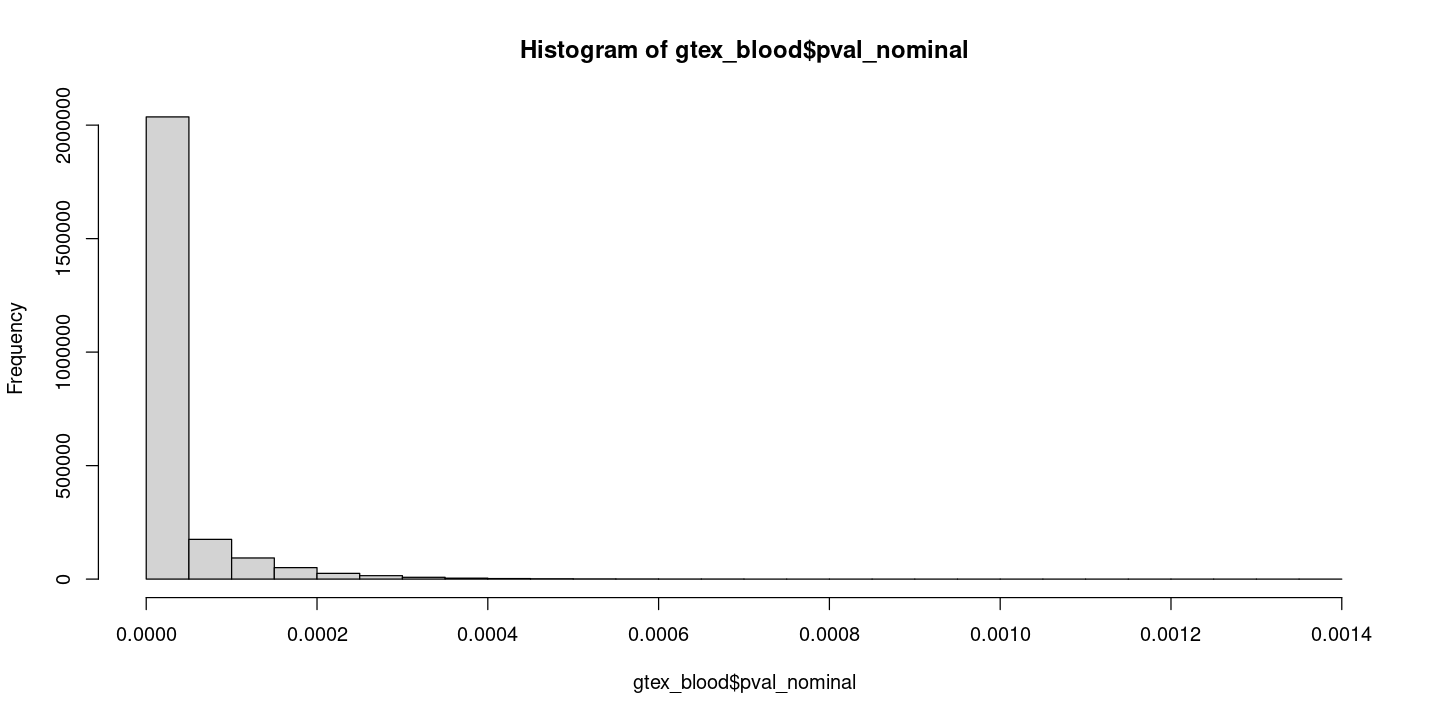

In [7]:
hist(gtex_blood$pval_nominal)

### Whole blood all

In [8]:
gtex_blood_all <- data.table::fread("/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL/all_pairs/GTEx_Analysis_v8_QTLs_GTEx_Analysis_v8_eQTL_all_associations_Whole_Blood.allpairs.txt.gz")
dim(gtex_blood_all)
head(gtex_blood_all)

[1] 149431316         9

gene_id           variant_id         tss_distance ma_samples ma_count
1 ENSG00000227232.5 chr1_13550_G_A_b38 -16003       19         19      
2 ENSG00000227232.5 chr1_14671_G_C_b38 -14882       17         17      
3 ENSG00000227232.5 chr1_14677_G_A_b38 -14876       69         69      
4 ENSG00000227232.5 chr1_16841_G_T_b38 -12712       56         56      
5 ENSG00000227232.5 chr1_16856_A_G_b38 -12697       17         17      
6 ENSG00000227232.5 chr1_17005_A_G_b38 -12548       20         20      
  maf       pval_nominal slope      slope_se 
1 0.0141791 0.7341510     0.0587242 0.1728370
2 0.0126866 0.8764780    -0.0282343 0.1815690
3 0.0514925 0.0487147    -0.1852120 0.0937735
4 0.0417910 0.3166470    -0.1045650 0.1043350
5 0.0126866 0.8858410     0.0265301 0.1847120
6 0.0149254 0.0328811    -0.3579620 0.1673910

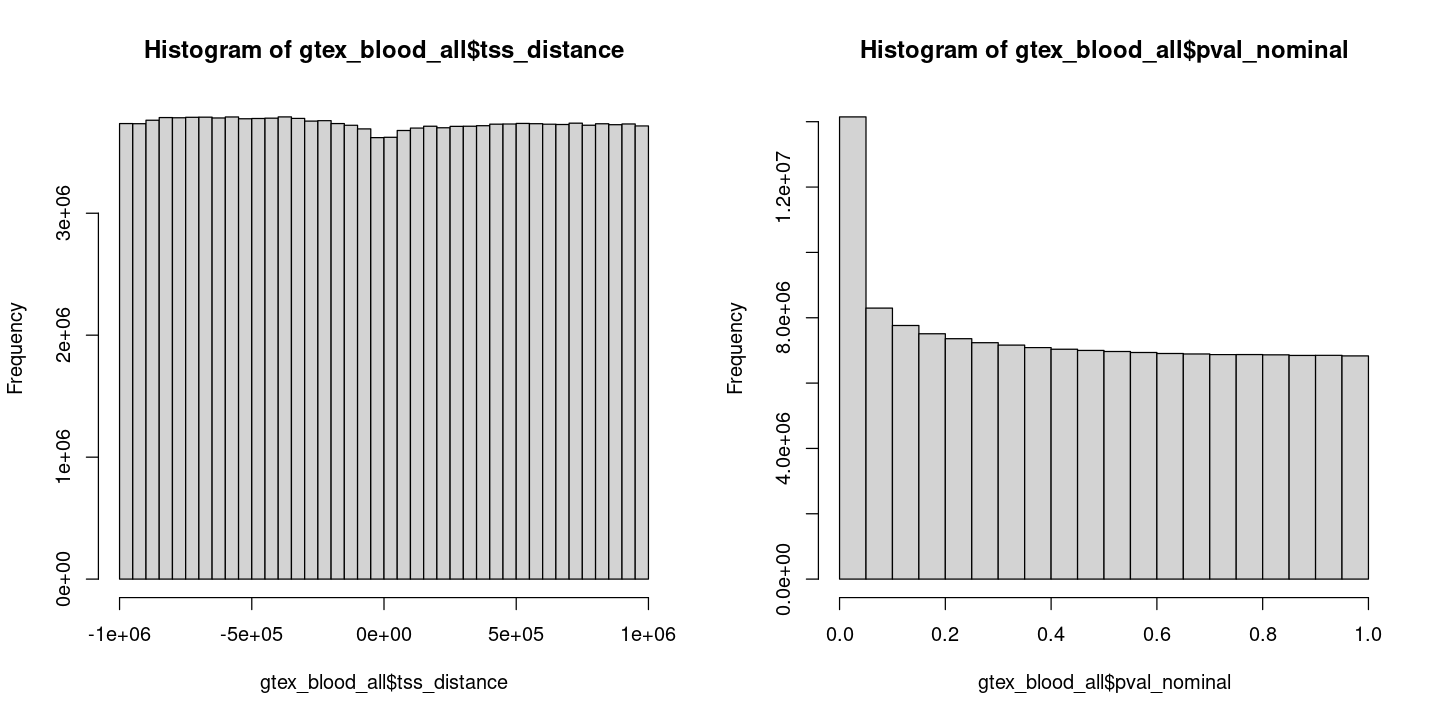

In [9]:
options(repr.plot.width=12, repr.plot.height=6)

par(mfrow = c(1, 2))

##distance distribution
hist(gtex_blood_all$tss_distance)

##p-value distribution
hist(gtex_blood_all$pval_nominal)

## Nascent pairs

### Blood significant 

In [10]:
nascent_blood <- data.table::fread("/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/correlations_significant/blood_adjPval_0.01.tsv.gz")
nascent_blood$pair_id <- paste0(nascent_blood$transcript_1, 
                             "~",
                             nascent_blood$transcript_2)
nascent_blood$nascent_gene_id <- as.character(lapply(strsplit(nascent_blood$transcript_1, ':'),
                                                    `[`, 1))
dim(nascent_blood)
head(nascent_blood)

[1] 2730402      25

transcript1_chrom transcript1_start transcript1_stop transcript_1     
1 chr10             46887             48546            TUBB8:NM_177987.3
2 chr10             46887             48546            TUBB8:NM_177987.3
3 chr10             46887             48546            TUBB8:NM_177987.3
4 chr10             46887             48546            TUBB8:NM_177987.3
5 chr10             46887             48546            TUBB8:NM_177987.3
6 chr10             46887             48546            TUBB8:NM_177987.3
  transcript1_score transcript1_strand transcript2_chrom transcript2_start
1 .                 -                  chr10             749695           
2 .                 -                  chr10             969848           
3 .                 -                  chr10             972700           
4 .                 -                  chr10             976990           
5 .                 -                  chr10             978565           
6 .                 -                  chr10             986401           
  transcript2_stop transcript_2        ⋯ nObs t          distance_tss
1 750013           chr10:749695-750013 ⋯  4   188.756638 -701308     
2 970172           chr10:969848-970172 ⋯ 40     3.935736 -921464     
3 973240           chr10:972700-973240 ⋯ 47     4.024305 -924424     
4 977210           chr10:976990-977210 ⋯ 44     3.547069 -928554     
5 978731           chr10:978565-978731 ⋯ 38     4.003165 -930102     
6 986877           chr10:986401-986877 ⋯ 48     4.750869 -938093     
  distance_tes position tissue percent_transcribed_both bidirectional_location
1 -702967      upstream blood   1.801802                intergenic            
2 -923123      upstream blood  18.018018                intergenic            
3 -926083      upstream blood  21.171171                intergenic            
4 -930213      upstream blood  19.819820                intergenic            
5 -931761      upstream blood  17.117117                intergenic            
6 -939752      upstream blood  21.621622                intergenic            
  pair_id                               nascent_gene_id
1 TUBB8:NM_177987.3~chr10:749695-750013 TUBB8          
2 TUBB8:NM_177987.3~chr10:969848-970172 TUBB8          
3 TUBB8:NM_177987.3~chr10:972700-973240 TUBB8          
4 TUBB8:NM_177987.3~chr10:976990-977210 TUBB8          
5 TUBB8:NM_177987.3~chr10:978565-978731 TUBB8          
6 TUBB8:NM_177987.3~chr10:986401-986877 TUBB8

In [11]:
nascent_blood$nascent_gene_id <- as.character(lapply(strsplit(nascent_blood$transcript_1, ':'),
                                                    `[`, 1))

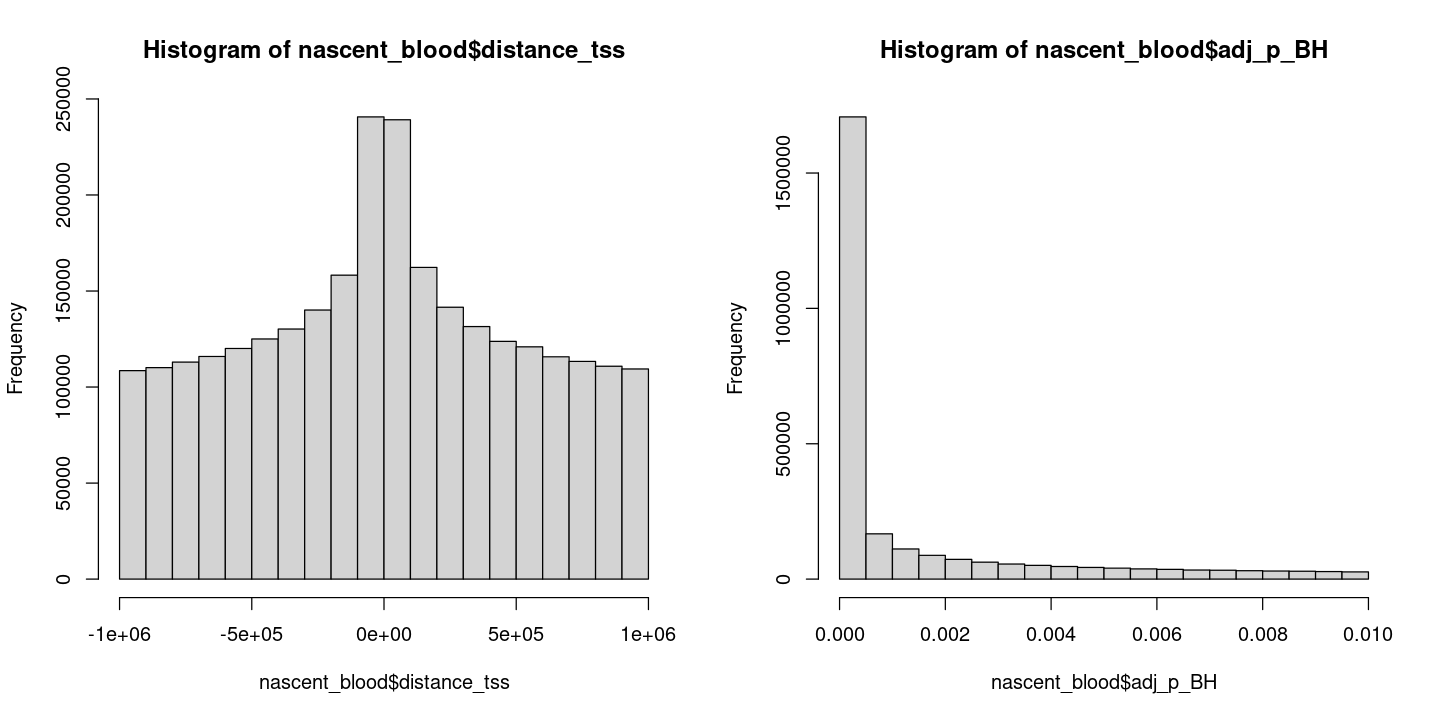

In [12]:
options(repr.plot.width=12, repr.plot.height=6)

par(mfrow = c(1, 2))

##distance distribution
hist(nascent_blood$distance_tss)

##p-value distribution
hist(nascent_blood$adj_p_BH)

## Overlap lists

In [13]:
## Loading all overlaps
#overlap_path <- '/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect'

##get paths
#overlap_files <- list.files(path=overlap_path, 
#                              pattern="*intersect.bed", 
#                                   full.names=TRUE)

##load overlaps
#overlap_bed_DT_list <- lapply(overlap_files, 
#                                   data.table::fread) 


In [14]:
##add tissue ids
#overlap_file_names <- basename(overlap_files)
 
#gtex_tissue_names <- gsub("_", " ", as.character(lapply(strsplit(overlap_file_names, '_gtex'), `[`, 1)))
#print("---GTEx Tissues---")
#gtex_tissue_names
#print("------------------")

In [15]:
#Name each of the lists. by tissue id
#names(overlap_bed_DT_list) <- gtex_tissue_names

#add a column with the tissue label from GTEx
#for (i in 1:length(overlap_bed_DT_list)){
    
#    overlap_bed_DT_list[[i]]$gtex_tissue <- gtex_tissue_names[i]

#}

In [16]:
##Combine all the tables
#overlap_bed_DT <- unique(do.call(rbind, overlap_bed_DT_list))
overlap_bed_DT <- data.table::fread("/scratch/Users/rusi2317/projects/meta_analysis_qc_reviews/processed_data/gtex_bidir_pairs_intersect/Whole_Blood_blood_gtex_bidir_intersect.bed")
dim(overlap_bed_DT)
head(overlap_bed_DT)

[1] 312741     10

V1   V2     V3     V4 V5 V6  V7                V8   V9     V10   
1 chr1 666027 666028 G  A  b38 ENSG00000227232.5 chr1 665707 666413
2 chr1  17555  17556 C  T  b38 ENSG00000238009.6 chr1  17453  17621
3 chr1  60350  60351 A  G  b38 ENSG00000238009.6 chr1  60170  60510
4 chr1  61919  61920 G  A  b38 ENSG00000238009.6 chr1  61756  62124
5 chr1  88143  88144 C  A  b38 ENSG00000238009.6 chr1  87654  88246
6 chr1  88235  88236 C  T  b38 ENSG00000238009.6 chr1  87654  88246

In [17]:
##Relabel the columns
colnames(overlap_bed_DT) <- c('chr_variant','start_variant','end_variant',
                             'ref_variant','alt_variant','ref', 'gene_id',
                             'chr_bidir','start_bidir','end_bidir') #,'bidir_tissue', 'gtex_tissue')

In [18]:
#Add a new column with a bidirectional ID
overlap_bed_DT[,("bidir_id"):=paste0(chr_bidir,':',
                                     start_bidir,'-',
                                     end_bidir)]

#Add a new column with a gtex SNP ID
overlap_bed_DT[,("gtex_snp_id"):=paste0(chr_variant,':',
                                     start_variant,'-',
                                     end_variant)]

#Add a new column with a variant ID
overlap_bed_DT[,("variant_id"):=paste0(chr_variant,'_',
                                       end_variant,'_',
                                       ref_variant,'_',
                                      alt_variant,'_',
                                      ref)]

print(paste0("GTEx pairs with variant overlapping bidirectionas = ", nrow(overlap_bed_DT)))
head(overlap_bed_DT, 3)

[1] "GTEx pairs with variant overlapping bidirectionas = 312741"


chr_variant start_variant end_variant ref_variant alt_variant ref
1 chr1        666027        666028      G           A           b38
2 chr1         17555         17556      C           T           b38
3 chr1         60350         60351      A           G           b38
  gene_id           chr_bidir start_bidir end_bidir bidir_id          
1 ENSG00000227232.5 chr1      665707      666413    chr1:665707-666413
2 ENSG00000238009.6 chr1       17453       17621    chr1:17453-17621  
3 ENSG00000238009.6 chr1       60170       60510    chr1:60170-60510  
  gtex_snp_id        variant_id         
1 chr1:666027-666028 chr1_666028_G_A_b38
2 chr1:17555-17556   chr1_17556_C_T_b38 
3 chr1:60350-60351   chr1_60351_A_G_b38

In [19]:
print(paste0("UNIQUE GTEx pairs with variant overlapping bidirectionas = ", 
             length(unique(overlap_bed_DT$gtex_snp_id))))


[1] "UNIQUE GTEx pairs with variant overlapping bidirectionas = 153414"


## eGene IDs

In [20]:
#path to GTEx 
egene_path <- '/Users/rusi2317/projects/meta_analysis_qc/hg38/enhancers/GTEx_Analysis_v8_eQTL'

#load egenes files
egene_files <- list.files(path=egene_path, 
                              pattern="*.egenes.txt.gz", 
                                   full.names=TRUE)
#store files in lists
egene_files_DT_list <- lapply(egene_files, 
                           data.table::fread)

#combine all egenes files
egene_files_DT <- do.call(rbind, egene_files_DT_list)

#get unique gene names and gene ids
egene_files_DT_uniq <- unique(egene_files_DT[,c('gene_id','gene_name')])
print(paste("GTEx Genes = ", nrow(egene_files_DT_uniq)))
head(egene_files_DT_uniq, 2)

[1] "GTEx Genes =  39832"


gene_id           gene_name    
1 ENSG00000227232.5 WASH7P       
2 ENSG00000268903.1 RP11-34P13.15

## Check region overlaps

### Genes

In [66]:
refseq <- data.table::fread("/scratch/Shares/dowell/genomes/hg38/ncbi/hg38_refseq_diff53prime_with_putatives.bed")
colnames(refseq) <- c("chrom","start","end","gene_transcript","score","strand")
refseq$gene_name <-as.character(lapply(strsplit(refseq$gene_transcript, ':'),
                                                    `[`, 1)) 
head(refseq)

chrom start end   gene_transcript            score strand gene_name  
1 chr1  11873 14409 DDX11L1:NR_046018.2        .     +      DDX11L1    
2 chr1  14361 29370 WASH7P:NR_024540.1         .     -      WASH7P     
3 chr1  17368 17436 MIR6859-1:NR_106918.1      .     -      MIR6859-1  
4 chr1  29773 35418 MIR1302-2HG:XR_007065314.1 .     +      MIR1302-2HG
5 chr1  30365 30503 MIR1302-2:NR_036051.1      .     +      MIR1302-2  
6 chr1  34610 36081 FAM138A:NR_026818.1        .     -      FAM138A

In [68]:
#overlapping genes
shared_genes1 <- intersect(unique(nascent_blood$nascent_gene_id),
                          unique(egene_files_DT_uniq$gene_name))

length(shared_genes1)

[1] 20940

In [67]:
#overlapping genes
shared_genes <- intersect(unique(refseq$gene_name),
                          unique(egene_files_DT_uniq$gene_name))

length(shared_genes)

[1] 21457

In [25]:
length(unique(egene_files_DT_uniq$gene_name))

[1] 39679

In [24]:
length(unique(nascent_blood$nascent_gene_id))

[1] 27082

In [29]:
##missing in egenes BUT in nascent
length(setdiff(unique(nascent_blood$nascent_gene_id), 
        unique(egene_files_DT_uniq$gene_name)))

[1] 6142

In [32]:
##missing in nascent BUT in egenes
length(setdiff(unique(egene_files_DT_uniq$gene_name),
               unique(nascent_blood$nascent_gene_id)))


[1] 18739

### Non-Genes

In [50]:
length(unique(overlap_bed_DT$variant_id))

[1] 153436

In [51]:
length(unique(overlap_bed_DT$bidir_id))

[1] 87276

In [55]:
length(unique(gtex_blood$variant_id))
length(unique(gtex_blood[gtex_blood$variant_id %in% unique(overlap_bed_DT$variant_id),]$variant_id))

[1] 1277338

[1] 153436

In [60]:
length(unique(nascent_blood$transcript_2))
length(unique(nascent_blood[nascent_blood$transcript_2 %in% unique(overlap_bed_DT$bidir_id),]$transcript_2))

[1] 385496

[1] 87276

# Get overlaps

## Shuffled pairs

In [34]:
#1: split pairs by chromosomes
#This is allow for the gene shuffling to be done in a single chromosome

#get chromosomes
chroms <- unique(nascent_blood$transcript1_chrom)

#create an empty list for adding the data.tables
nascent_blood_chrom_list <- list()

#loop through and filter the chromosome pairs
for (i in chroms){

    nascent_blood_chrom_list[[i]] <- subset(nascent_blood,
                                          transcript1_chrom==i)
}

length(nascent_blood_chrom_list)

[1] 24

In [35]:
number_eqtl <- list()
number_pairs <- list()
seed_values <- 1:20

for (i in 1:20){
    
    #1. shuffle the pairs
    nascent_blood_shuffle_list <- mclapply(nascent_blood_chrom_list, 
                                           shuffle_genes, 
                                           seed=i,  
                                           mc.cores = 10)
    
    nascent_blood_shuffle <- do.call(rbind, nascent_blood_shuffle_list)
    
    #2. get overlaps 
    overlap_shuffle <- map_overlaps(overlap_DT = overlap_bed_DT,
                                    egene_ids = egene_files_DT_uniq, 
                                    nascent_pairs = nascent_blood_shuffle)
    
    #3. save the overlaps
    number_eqtl[[i]] <- overlap_shuffle[[1]]
    number_pairs[[i]] <- overlap_shuffle[[2]]
    
}

In [69]:
gtex_blood_geneid <- merge(gtex_blood, egene_files_DT_uniq, by="gene_id")

gtex_blood_shared <- gtex_blood_geneid[gtex_blood_geneid$gene_name %in% shared_genes & 
                                       gtex_blood_geneid$variant_id %in% unique(overlap_bed_DT$variant_id),]

nascent_blood_shared <- nascent_blood[nascent_blood$nascent_gene_id %in% shared_genes &
                                      nascent_blood$transcript_2 %in% unique(overlap_bed_DT$bidir_id) ,]


In [37]:
shuffle_pair_summary <- data.frame(seed_value=seed_values,
                                   number_eqtl = as.numeric(number_eqtl),
                                  number_pairs =  as.numeric(number_pairs))
shuffle_pair_summary$percent_eqtl = (shuffle_pair_summary$number_eqtl/length(unique(gtex_blood$variant_id)))*100
shuffle_pair_summary$percent_pairs = (shuffle_pair_summary$number_pairs/length(unique(nascent_blood$pair_id)))*100
shuffle_pair_summary

seed_value number_eqtl number_pairs percent_eqtl percent_pairs
1   1         3739        2699         0.2927181    0.09884991   
2   2         3679        2614         0.2880209    0.09573682   
3   3         3930        2693         0.3076711    0.09863017   
4   4         3897        2707         0.3050876    0.09914291   
5   5         3883        2718         0.3039916    0.09954578   
6   6         3783        2648         0.2961628    0.09698206   
7   7         3686        2626         0.2885689    0.09617631   
8   8         3756        2670         0.2940490    0.09778780   
9   9         3780        2658         0.2959279    0.09734830   
10 10         3802        2720         0.2976503    0.09961903   
11 11         3908        2633         0.3059488    0.09643269   
12 12         3737        2645         0.2925616    0.09687218   
13 13         3929        2743         0.3075928    0.10046140   
14 14         4040        2767         0.3162828    0.10134039   
15 15         3809        2654         0.2981983    0.09720180   
16 16         3857        2760         0.3019561    0.10108402   
17 17         3973        2668         0.3110375    0.09771455   
18 18         3967        2798         0.3105678    0.10247575   
19 19         3749        2622         0.2935010    0.09602982   
20 20         3931        2726         0.3077494    0.09983878

In [62]:
shuffle_pair_summary2 <- data.frame(seed_value=seed_values,
                                   number_eqtl = as.numeric(number_eqtl),
                                  number_pairs =  as.numeric(number_pairs))
shuffle_pair_summary2$percent_eqtl = (shuffle_pair_summary2$number_eqtl/length(unique(gtex_blood_shared$variant_id)))*100
shuffle_pair_summary2$percent_pairs = (shuffle_pair_summary2$number_pairs/length(unique(nascent_blood_shared$pair_id)))*100
shuffle_pair_summary2

seed_value number_eqtl number_pairs percent_eqtl percent_pairs
1   1         3739        2699         2.735647     0.3789097    
2   2         3679        2614         2.691748     0.3669766    
3   3         3930        2693         2.875392     0.3780673    
4   4         3897        2707         2.851248     0.3800328    
5   5         3883        2718         2.841005     0.3815770    
6   6         3783        2648         2.767840     0.3717498    
7   7         3686        2626         2.696869     0.3686613    
8   8         3756        2670         2.748085     0.3748384    
9   9         3780        2658         2.765645     0.3731537    
10 10         3802        2720         2.781741     0.3818578    
11 11         3908        2633         2.859296     0.3696440    
12 12         3737        2645         2.734184     0.3713287    
13 13         3929        2743         2.874661     0.3850868    
14 14         4040        2767         2.955874     0.3884561    
15 15         3809        2654         2.786862     0.3725922    
16 16         3857        2760         2.821982     0.3874734    
17 17         3973        2668         2.906853     0.3745576    
18 18         3967        2798         2.902463     0.3928082    
19 19         3749        2622         2.742963     0.3680997    
20 20         3931        2726         2.876124     0.3827002

## True pairs

In [44]:
map_overlaps_blood <- map_overlaps(overlap_bed_DT, 
                                   egene_files_DT_uniq, 
                                   nascent_blood)

In [45]:
map_overlaps_blood

$eqtl_overlap
[1] 62488

$nascent_pair_overlap
[1] 56050

In [46]:
as.data.frame(map_overlaps_blood)


eqtl_overlap nascent_pair_overlap
1 62488        56050

In [47]:
map_overlaps_blood_DT <- as.data.table(map_overlaps_blood)
map_overlaps_blood_DT$percent_eqtl <- (map_overlaps_blood_DT$eqtl_overlap/length(unique(gtex_blood$variant_id)))*100
map_overlaps_blood_DT$percent_pairs <- (map_overlaps_blood_DT$nascent_pair_overlap/length(unique(nascent_blood$pair_id)))*100
map_overlaps_blood_DT$p_value_nascent <- empirical_pval(as.numeric(shuffle_pair_summary$percent_pairs),
                                                        map_overlaps_blood_DT$percent_pairs, 
                                                        alternative = "greater")
map_overlaps_blood_DT$p_value_eqtl <- empirical_pval(as.numeric(shuffle_pair_summary$percent_eqtl),
                                                        map_overlaps_blood_DT$percent_eqtl, 
                                                        alternative = "greater")

map_overlaps_blood_DT

eqtl_overlap nascent_pair_overlap percent_eqtl percent_pairs p_value_nascent
1 62488        56050                4.892049     2.052811      0.04761905     
  p_value_eqtl
1 0.04761905

In [70]:
map_overlaps_blood_DT2 <- as.data.table(map_overlaps_blood)
map_overlaps_blood_DT2$percent_eqtl <- (map_overlaps_blood_DT2$eqtl_overlap/length(unique(gtex_blood_shared$variant_id)))*100
map_overlaps_blood_DT2$percent_pairs <- (map_overlaps_blood_DT2$nascent_pair_overlap/length(unique(nascent_blood_shared$pair_id)))*100
map_overlaps_blood_DT2$p_value_nascent <- empirical_pval(as.numeric(shuffle_pair_summary2$percent_pairs),
                                                        map_overlaps_blood_DT2$percent_pairs, 
                                                        alternative = "greater")
map_overlaps_blood_DT2$p_value_eqtl <- empirical_pval(as.numeric(shuffle_pair_summary2$percent_eqtl),
                                                        map_overlaps_blood_DT2$percent_eqtl, 
                                                        alternative = "greater")

map_overlaps_blood_DT2

eqtl_overlap nascent_pair_overlap percent_eqtl percent_pairs p_value_nascent
1 62488        56050                45.68538     7.868798      0.04761905     
  p_value_eqtl
1 0.04761905

In [37]:
cat(colnames(map_overlaps_blood_DT))
cat("\n")
cat(as.character(map_overlaps_blood_DT))

eqtl_overlap nascent_pair_overlap percent_eqtl percent_pairs p_value_nascent p_value_eqtl
62488 56050 4.89204893301538 2.0528112710143 0.0476190476190476 0.0476190476190476

In [29]:
as.numeric(shuffle_pair_summary$percent_eqtl)
as.numeric(shuffle_pair_summary$percent_etl)

[1] 0.2927181 0.2880209 0.3076711 0.3050876 0.3039916 0.2961628 0.2885689
 [8] 0.2940490 0.2959279 0.2976503 0.3059488 0.2925616 0.3075928 0.3162828
[15] 0.2981983 0.3019561 0.3110375 0.3105678 0.2935010 0.3077494

In [30]:
map_overlaps_blood_DT$percent_eqtl

[1] 4.892049

# Combine data.tables

## Merge to get GTEx gene IDs

In [14]:
overlap_bed_DT_genename <- merge(overlap_bed_DT, 
                                 egene_files_DT_uniq,
                                 by='gene_id')

dim(overlap_bed_DT_genename)
head(overlap_bed_DT_genename, 2)

[1] 312741     14

gene_id            chr_variant start_variant end_variant ref_variant
1 ENSG00000000457.13 chr1        169662404     169662405   C          
2 ENSG00000000457.13 chr1        169664706     169664707   T          
  alt_variant ref chr_bidir start_bidir end_bidir bidir_id                
1 T           b38 chr1      169661848   169662444 chr1:169661848-169662444
2 C           b38 chr1      169664277   169665611 chr1:169664277-169665611
  gtex_snp_id              variant_id             gene_name
1 chr1:169662404-169662405 chr1_169662405_C_T_b38 SCYL3    
2 chr1:169664706-169664707 chr1_169664707_T_C_b38 SCYL3

## Merge to get Nascent pairs

In [15]:
overlap_bed_DT_genename_bidirs <- merge(overlap_bed_DT_genename,
                                        nascent_blood,
                                       by.x='bidir_id',
                                       by.y='transcript_2',
                                       all = TRUE, 
                                        allow.cartesian=TRUE)

dim(overlap_bed_DT_genename_bidirs)
head(overlap_bed_DT_genename_bidirs, 2)

[1] 5776335      37

bidir_id                  gene_id            chr_variant start_variant
1 chr10:100000773-100001115 NA                 NA                 NA    
2 chr10:100001829-100002093 ENSG00000196072.11 chr10       100002037    
  end_variant ref_variant alt_variant ref chr_bidir start_bidir ⋯ adj_p_BH   
1        NA   NA          NA          NA  NA               NA   ⋯ 0.000303940
2 100002038   G           A           b38 chr10     100001829   ⋯ 0.009228528
  nObs t        distance_tss distance_tes position   tissue
1 23   5.317216 -735201      -746493      upstream   blood 
2 10   4.747783  268978       245827      downstream blood 
  percent_transcribed_both bidirectional_location
1 10.360360                intragenic            
2  4.504505                intragenic            
  pair_id                                      
1 PAX2:NM_001374303.1~chr10:100000773-100001115
2 CUTC:NM_015960.3~chr10:100001829-100002093

In [16]:
##overlaps will have complete cases
overlap_bed_DT_genename_bidirs_complete <- overlap_bed_DT_genename_bidirs[complete.cases(overlap_bed_DT_genename_bidirs),]
dim(overlap_bed_DT_genename_bidirs_complete)
head(overlap_bed_DT_genename_bidirs_complete, 2)

[1] 3890151      37

bidir_id                  gene_id            chr_variant start_variant
1 chr10:100001829-100002093 ENSG00000196072.11 chr10       100002037    
2 chr10:100005357-100005829 ENSG00000023839.10 chr10       100005357    
  end_variant ref_variant alt_variant ref chr_bidir start_bidir ⋯ adj_p_BH   
1 100002038   G           A           b38 chr10     100001829   ⋯ 0.009228528
2 100005358   G           C           b38 chr10     100005357   ⋯ 0.004952783
  nObs t        distance_tss distance_tes position   tissue
1 10   4.747783 268978       245827       downstream blood 
2 38   3.710705 231709       231562       downstream blood 
  percent_transcribed_both bidirectional_location
1  4.504505                intragenic            
2 17.117117                intragenic            
  pair_id                                      
1 CUTC:NM_015960.3~chr10:100001829-100002093   
2 SNORA12:NR_002954.1~chr10:100005357-100005829

In [17]:
overlap_bed_DT_genename_bidirs_complete$nascent_gene_id <- as.character(lapply(strsplit(overlap_bed_DT_genename_bidirs_complete$transcript_1, ':'),
                                                      `[`, 1))

# Get overlaps

## Get overlapping gene names

In [18]:
overlap_bed_DT_nascent_gtex <- subset(overlap_bed_DT_genename_bidirs_complete,
                                     gene_name==nascent_gene_id)
dim(overlap_bed_DT_nascent_gtex)
head(overlap_bed_DT_nascent_gtex)

[1] 89581    38

bidir_id                  gene_id            chr_variant start_variant
1 chr10:100092382-100092586 ENSG00000023839.10 chr10       100092433    
2 chr10:100101339-100101911 ENSG00000196072.11 chr10       100101677    
3 chr10:100101339-100101911 ENSG00000196072.11 chr10       100101864    
4 chr10:100110691-100111179 ENSG00000095485.16 chr10       100110794    
5 chr10:100110691-100111179 ENSG00000095485.16 chr10       100111178    
6 chr10:100110691-100111179 ENSG00000196072.11 chr10       100110794    
  end_variant ref_variant alt_variant ref chr_bidir start_bidir ⋯ nObs t       
1 100092434   G           A           b38 chr10     100092382   ⋯ 98   8.169136
2 100101678   G           A           b38 chr10     100101339   ⋯ 32   5.662295
3 100101865   T           C           b38 chr10     100101339   ⋯ 32   5.662295
4 100110795   TTA         T           b38 chr10     100110691   ⋯ 33   3.472088
5 100111179   C           T           b38 chr10     100110691   ⋯ 33   3.472088
6 100110795   TTA         T           b38 chr10     100110691   ⋯ 33   4.897793
  distance_tss distance_tes position   tissue percent_transcribed_both
1 309095       239890       downstream blood  44.14414                
2 183989       171652       downstream blood  14.41441                
3 183989       171652       downstream blood  14.41441                
4 155953       121362       downstream blood  14.86486                
5 155953       121362       downstream blood  14.86486                
6 174679       162342       downstream blood  14.86486                
  bidirectional_location pair_id                                         
1 intergenic             ABCC2:NM_000392.5~chr10:100092382-100092586     
2 intergenic             BLOC1S2:NM_001001342.2~chr10:100101339-100101911
3 intergenic             BLOC1S2:NM_001001342.2~chr10:100101339-100101911
4 intergenic             CWF19L1:NM_018294.6~chr10:100110691-100111179   
5 intergenic             CWF19L1:NM_018294.6~chr10:100110691-100111179   
6 intergenic             BLOC1S2:NM_001001342.2~chr10:100110691-100111179
  nascent_gene_id
1 ABCC2          
2 BLOC1S2        
3 BLOC1S2        
4 CWF19L1        
5 CWF19L1        
6 BLOC1S2

In [19]:
colnames(overlap_bed_DT_nascent_gtex)

[1] "bidir_id"                 "gene_id"                 
 [3] "chr_variant"              "start_variant"           
 [5] "end_variant"              "ref_variant"             
 [7] "alt_variant"              "ref"                     
 [9] "chr_bidir"                "start_bidir"             
[11] "end_bidir"                "gtex_snp_id"             
[13] "variant_id"               "gene_name"               
[15] "transcript1_chrom"        "transcript1_start"       
[17] "transcript1_stop"         "transcript_1"            
[19] "transcript1_score"        "transcript1_strand"      
[21] "transcript2_chrom"        "transcript2_start"       
[23] "transcript2_stop"         "transcript2_score"       
[25] "transcript2_strand"       "pcc"                     
[27] "pval"                     "adj_p_BH"                
[29] "nObs"                     "t"                       
[31] "distance_tss"             "distance_tes"            
[33] "position"                 "tissue"                  
[35] "percent_transcribed_both" "bidirectional_location"  
[37] "pair_id"                  "nascent_gene_id"

In [20]:
head(overlap_bed_DT_nascent_gtex$gtex_snp_id)

[1] "chr10:100092433-100092434" "chr10:100101677-100101678"
[3] "chr10:100101864-100101865" "chr10:100110794-100110795"
[5] "chr10:100111178-100111179" "chr10:100110794-100110795"

In [21]:
#overlap_bed_DT_nascent_gtex$variant_id <- paste(overlap_bed_DT_nascent_gtex$chr_variant,
#                                                overlap_bed_DT_nascent_gtex$end_variant,
#                                                overlap_bed_DT_nascent_gtex$ref_variant,
#                                                overlap_bed_DT_nascent_gtex$alt_variant,
#                                                overlap_bed_DT_nascent_gtex$ref,
#                                                sep="_")

## Blood

In [22]:
head(gtex_blood)

variant_id          gene_id           tss_distance ma_samples ma_count
1 chr1_64764_C_T_b38  ENSG00000227232.5   35211       79         80     
2 chr1_665098_G_A_b38 ENSG00000227232.5  635545      140        146     
3 chr1_666028_G_A_b38 ENSG00000227232.5  636475      125        131     
4 chr1_17556_C_T_b38  ENSG00000238009.6 -111667       27         27     
5 chr1_58814_G_A_b38  ENSG00000238009.6  -70409      109        119     
6 chr1_60351_A_G_b38  ENSG00000238009.6  -68872       83         92     
  maf       pval_nominal slope    slope_se  pval_nominal_threshold
1 0.0597015 1.72756e-09  0.516614 0.0844652 0.000393213           
2 0.1089550 8.84898e-13  0.462697 0.0633368 0.000393213           
3 0.0977612 3.85133e-13  0.489662 0.0659359 0.000393213           
4 0.0201493 1.48531e-06  0.760661 0.1564470 0.000333231           
5 0.0888060 1.49434e-18  0.636831 0.0700984 0.000333231           
6 0.0686567 6.43685e-13  0.575975 0.0783446 0.000333231           
  min_pval_nominal pval_beta  
1 3.85133e-13      1.05258e-09
2 3.85133e-13      1.05258e-09
3 3.85133e-13      1.05258e-09
4 4.99434e-31      1.05973e-25
5 4.99434e-31      1.05973e-25
6 4.99434e-31      1.05973e-25

In [23]:
overlap_bed_DT_nascent_gtex_blood <- merge(overlap_bed_DT_nascent_gtex, 
                                          gtex_blood,
                                          by="variant_id")

dim(overlap_bed_DT_nascent_gtex_blood)
head(overlap_bed_DT_nascent_gtex_blood)


[1] 314337     49

variant_id                bidir_id                  gene_id.x         
1 chr10_100092434_G_A_b38   chr10:100092382-100092586 ENSG00000023839.10
2 chr10_100101678_G_A_b38   chr10:100101339-100101911 ENSG00000196072.11
3 chr10_100101678_G_A_b38   chr10:100101339-100101911 ENSG00000196072.11
4 chr10_100101865_T_C_b38   chr10:100101339-100101911 ENSG00000196072.11
5 chr10_100101865_T_C_b38   chr10:100101339-100101911 ENSG00000196072.11
6 chr10_100110795_TTA_T_b38 chr10:100110691-100111179 ENSG00000095485.16
  chr_variant start_variant end_variant ref_variant alt_variant ref chr_bidir ⋯
1 chr10       100092433     100092434   G           A           b38 chr10     ⋯
2 chr10       100101677     100101678   G           A           b38 chr10     ⋯
3 chr10       100101677     100101678   G           A           b38 chr10     ⋯
4 chr10       100101864     100101865   T           C           b38 chr10     ⋯
5 chr10       100101864     100101865   T           C           b38 chr10     ⋯
6 chr10       100110794     100110795   TTA         T           b38 chr10     ⋯
  tss_distance ma_samples ma_count maf       pval_nominal slope     slope_se 
1  309702       14         14      0.0104478 1.15025e-04  -0.378102 0.0973949
2 -166002      344        403      0.3007460 2.59593e-23   0.193735 0.0186709
3 -185034      344        403      0.3007460 3.82756e-11   0.112607 0.0167180
4 -165815      337        393      0.2932840 1.10362e-22   0.193335 0.0189315
5 -184847      337        393      0.2932840 4.17773e-11   0.113691 0.0169132
6 -156885      327        381      0.2843280 1.09378e-22   0.198705 0.0194554
  pval_nominal_threshold min_pval_nominal pval_beta  
1 0.000241564            4.88376e-07      1.11440e-03
2 0.000173475            3.59617e-32      7.42636e-27
3 0.000167096            1.43064e-13      1.52745e-09
4 0.000173475            3.59617e-32      7.42636e-27
5 0.000167096            1.43064e-13      1.52745e-09
6 0.000173475            3.59617e-32      7.42636e-27

In [187]:
nrow(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','gene_id.x')]))

print(paste("N overlapping eQTLs = ",
           nrow(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','gene_id.x')]))))

print(paste("% overlapping eQTLs = ",
           nrow(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','gene_id.x')]))/nrow(gtex_blood)*100))

[1] 89581

[1] "N overlapping eQTLs =  89581"
[1] "% overlapping eQTLs =  3.70989123488965"


In [ ]:
nrow(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold',
                                               'gene_name','transcript_1',
                                                'pair_id')]))

print(paste("N bidirectionals overlapping eQTLs = ",
           length(unique(overlap_bed_DT_nascent_gtex_blood$pair_id))))

print(paste("% bidirectionals overlapping eQTLs = ",
           (length(unique(overlap_bed_DT_nascent_gtex_blood$pair_id))/nrow(nascent_blood))*100))

### Comparing significance

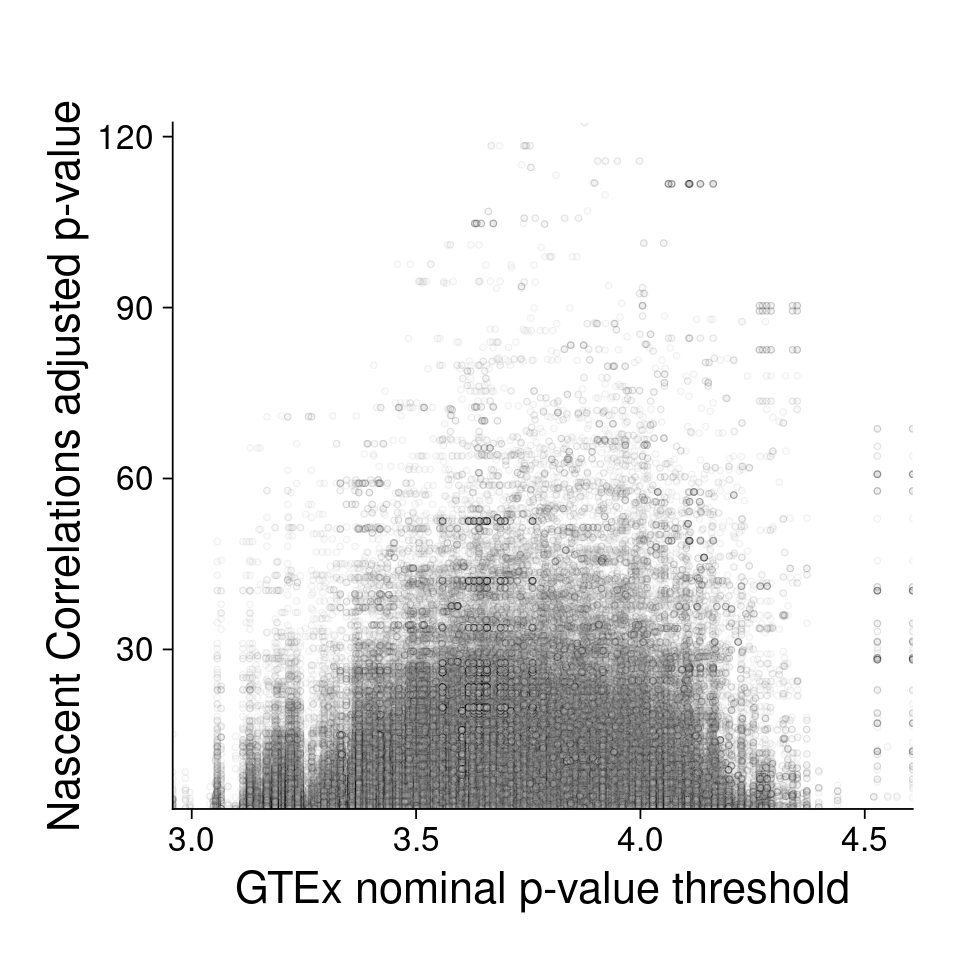

In [25]:
options(repr.plot.width=8, repr.plot.height=8)

blood_overlapping_gtex <- ggplot(unique(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold',
                                               'gene_name','transcript_1')]), 
       aes(x = -log(pval_nominal_threshold, 10), 
           y = -log(adj_p_BH, 10))) + 
geom_point(shape=21,
           color="black", 
           alpha=0.05,
           fill="gray80") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle(" ") +
xlab("GTEx nominal p-value threshold") +
ylab("Nascent Correlations adjusted p-value") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex

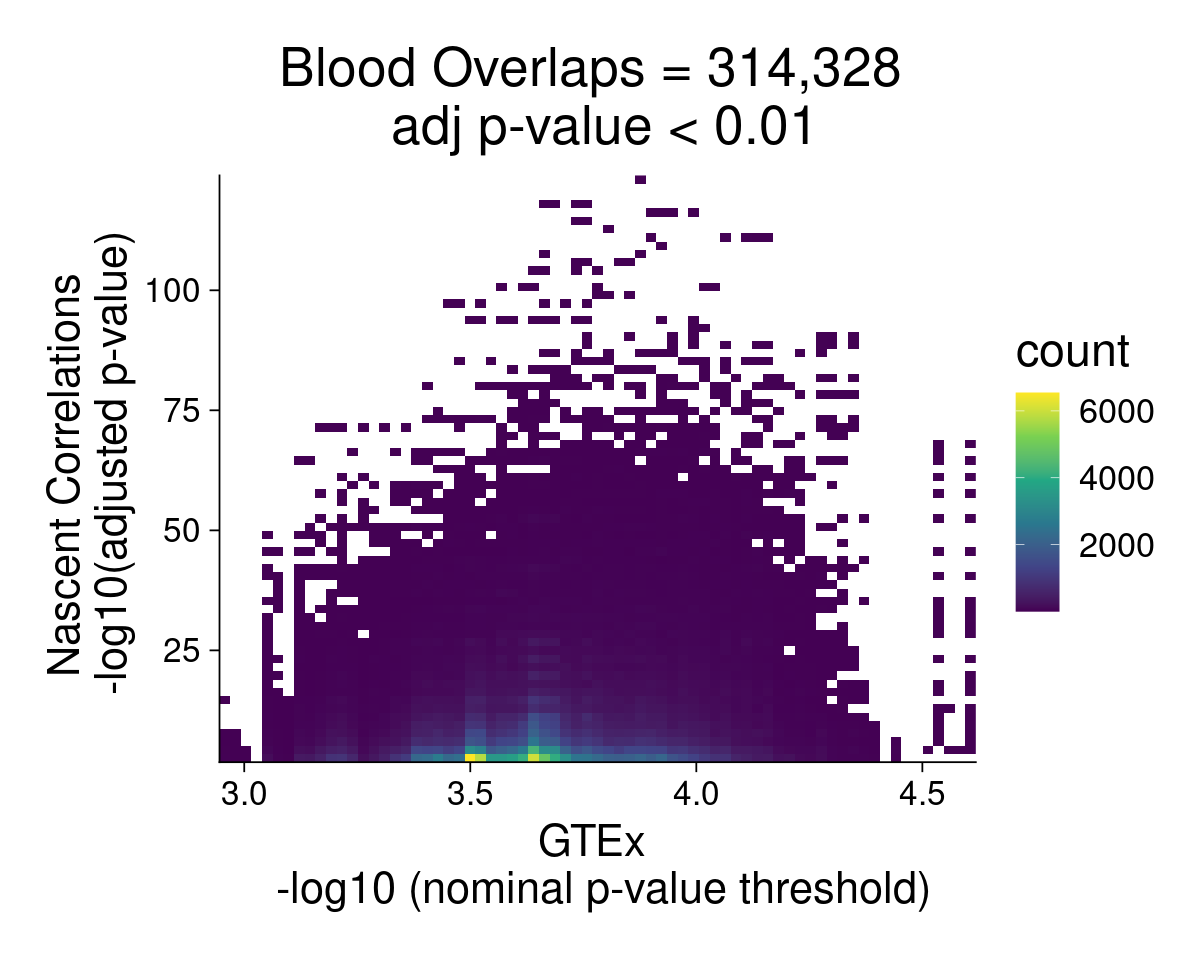

In [26]:
options(repr.plot.width=10, repr.plot.height=8)

blood_overlapping_gtex2 <- ggplot(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold',
                                               'gene_name','transcript_1')]), 
       aes(x = -log(pval_nominal_threshold, 10), 
           y = -log(adj_p_BH, 10))) + 
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Blood Overlaps = 314,328 \n adj p-value < 0.01") +
xlab("GTEx \n -log10 (nominal p-value threshold)") +
ylab("Nascent Correlations \n -log10(adjusted p-value)") +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 28), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex2

In [27]:
options(repr.plot.width=10, repr.plot.height=8)

blood_overlapping_gtex3 <- ggplot(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold',
                                               'gene_name','transcript_1')]), 
       aes(x = pval_nominal_threshold, 
           y = adj_p_BH)) + 
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("Blood Overlaps = 314,328 \n adj p-value < 0.01") +
xlab("GTEx \n nominal p-value threshold") +
ylab("Nascent Correlations \n adjusted p-value") +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex3

### Comparing pcc to slope

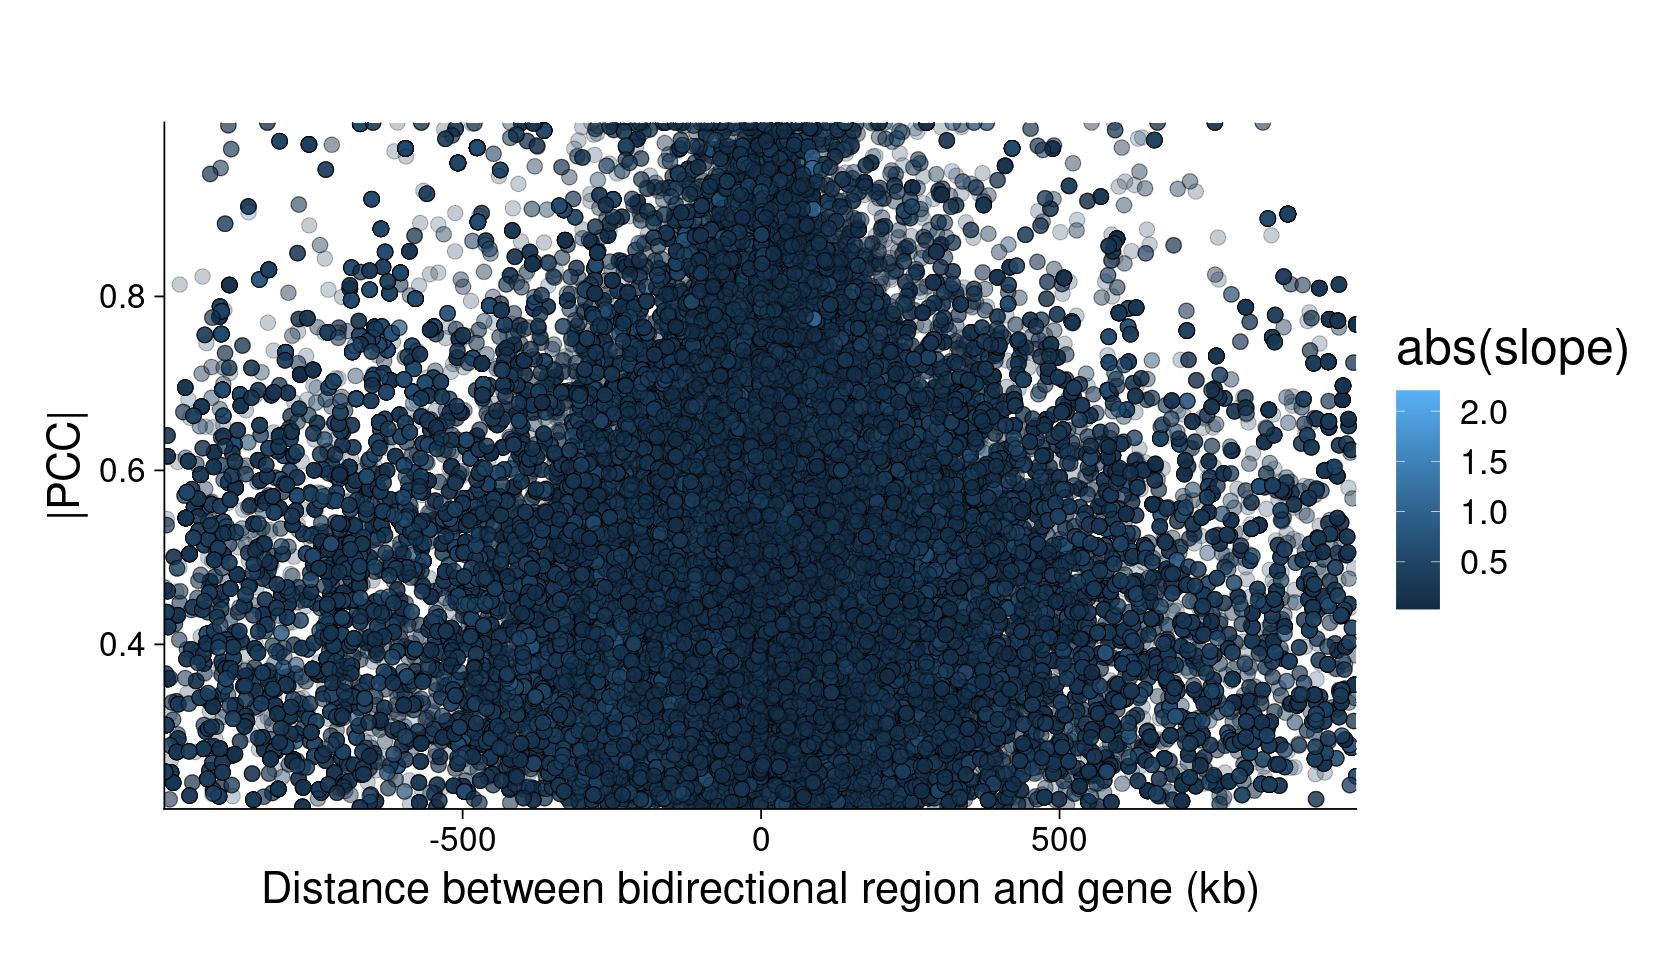

In [28]:
options(repr.plot.width=14, repr.plot.height=8)

blood_overlapping_gtex_dist <- ggplot(unique(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')]), 
       aes(x = distance_tss/1000, 
           y = abs(pcc),
          fill = abs(slope))) + 
geom_point(shape=21,
           size=4,
           color="black", 
           alpha=0.25) +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle(" ") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5)) +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist

In [29]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist2 <- ggplot(unique(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')]), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')]
                                                    ))),
         color="blue") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.01") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist2

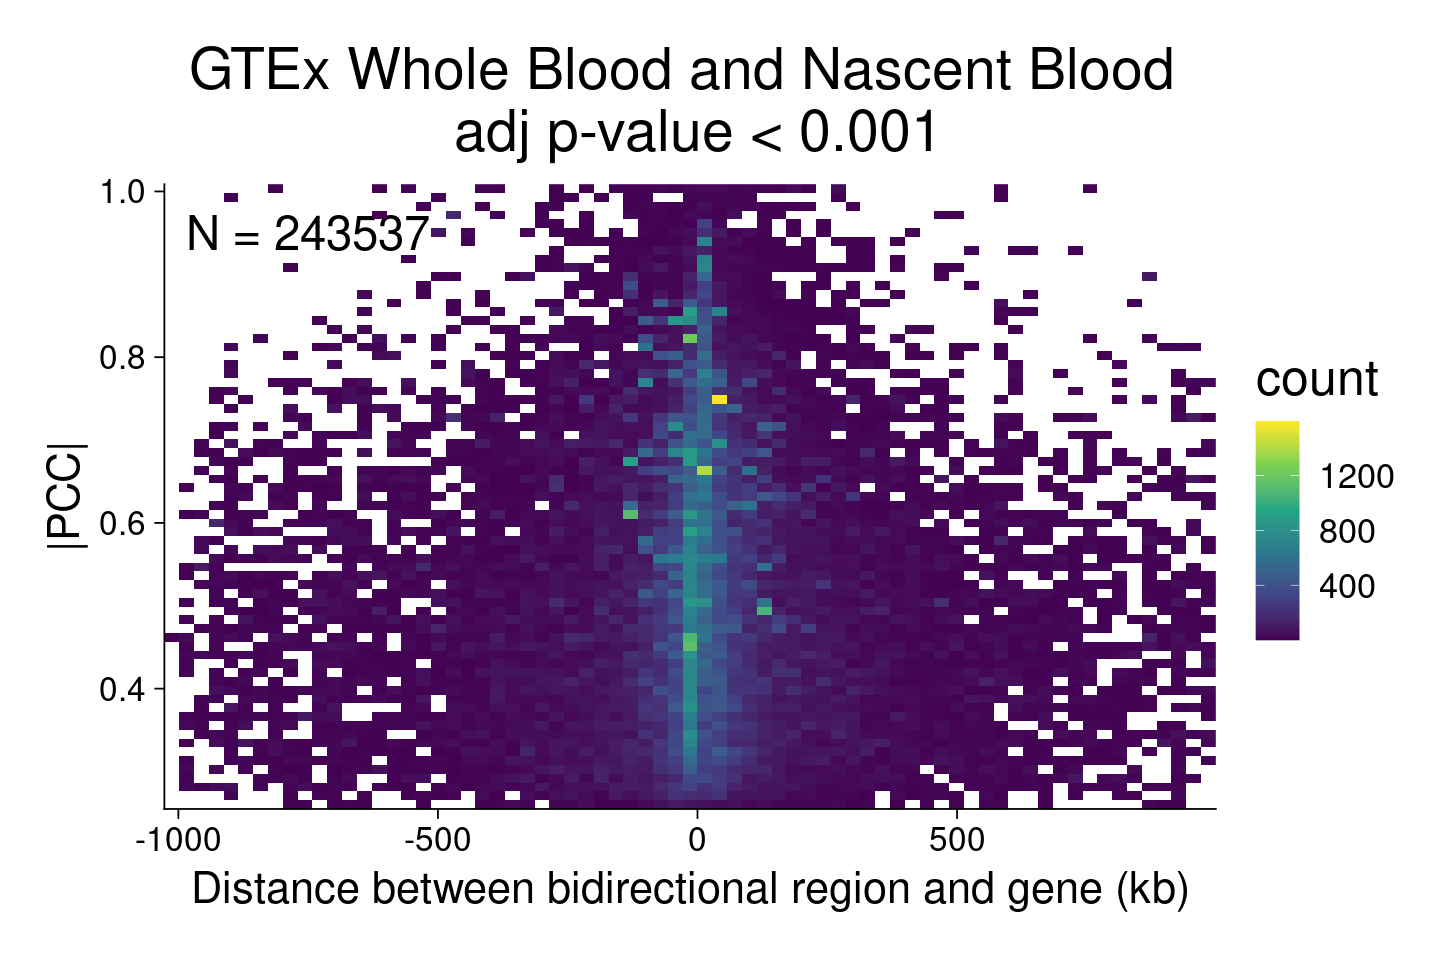

In [30]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist3 <- ggplot(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.001)), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.001)))),
         color="black") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.001") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist3

In [31]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist4 <- ggplot(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.0001)), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.0001)))),
         color="black") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.0001") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist4

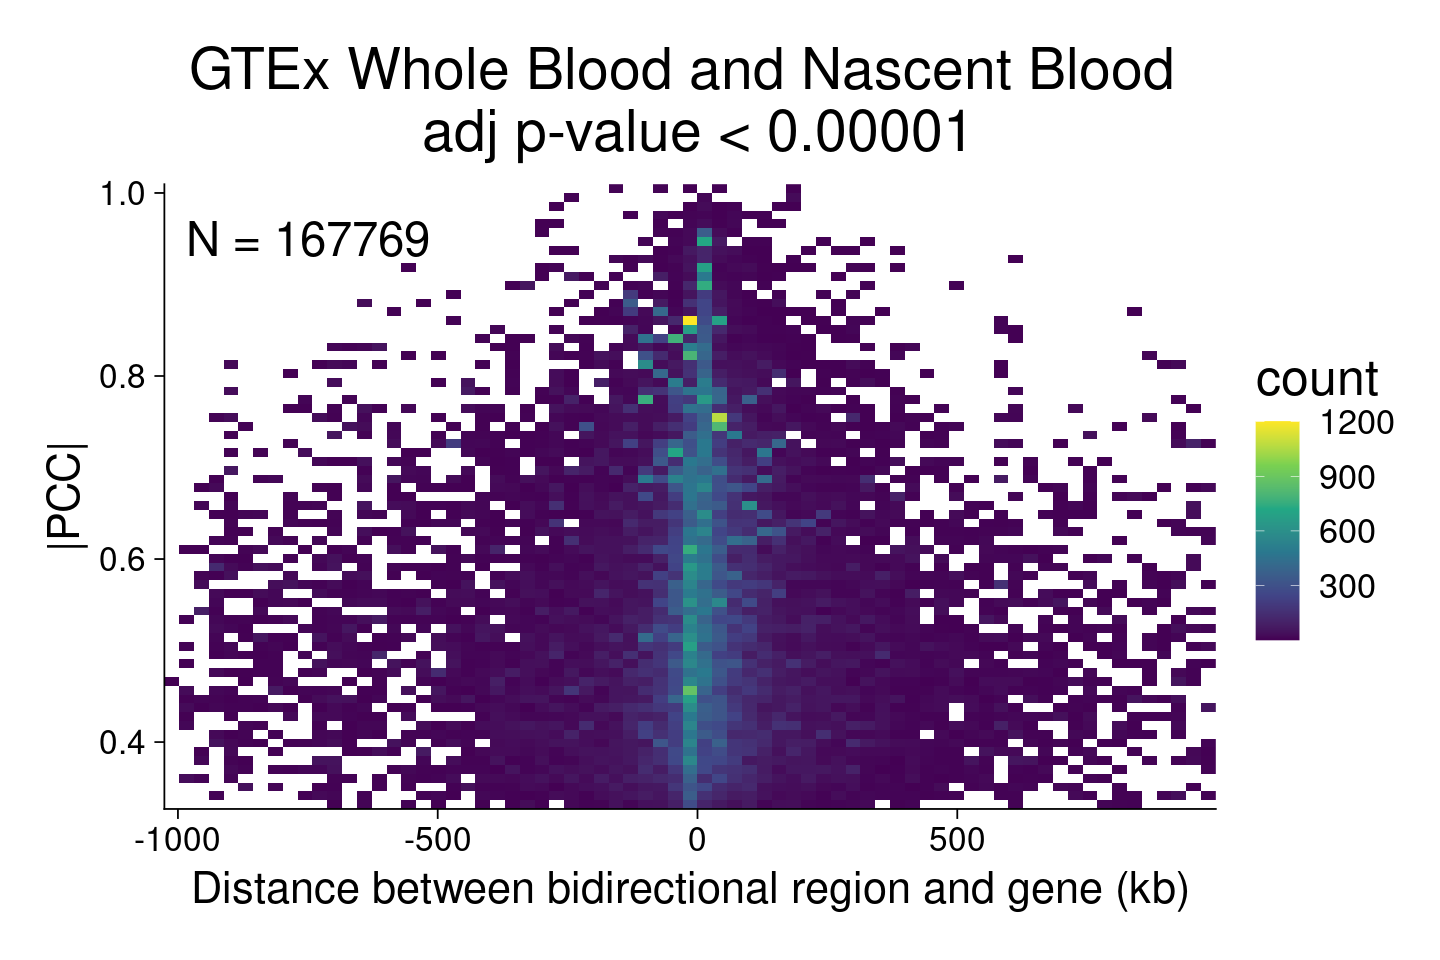

In [32]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist5 <- ggplot(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.00001)), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.00001)))),
         color="black") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.00001") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist5

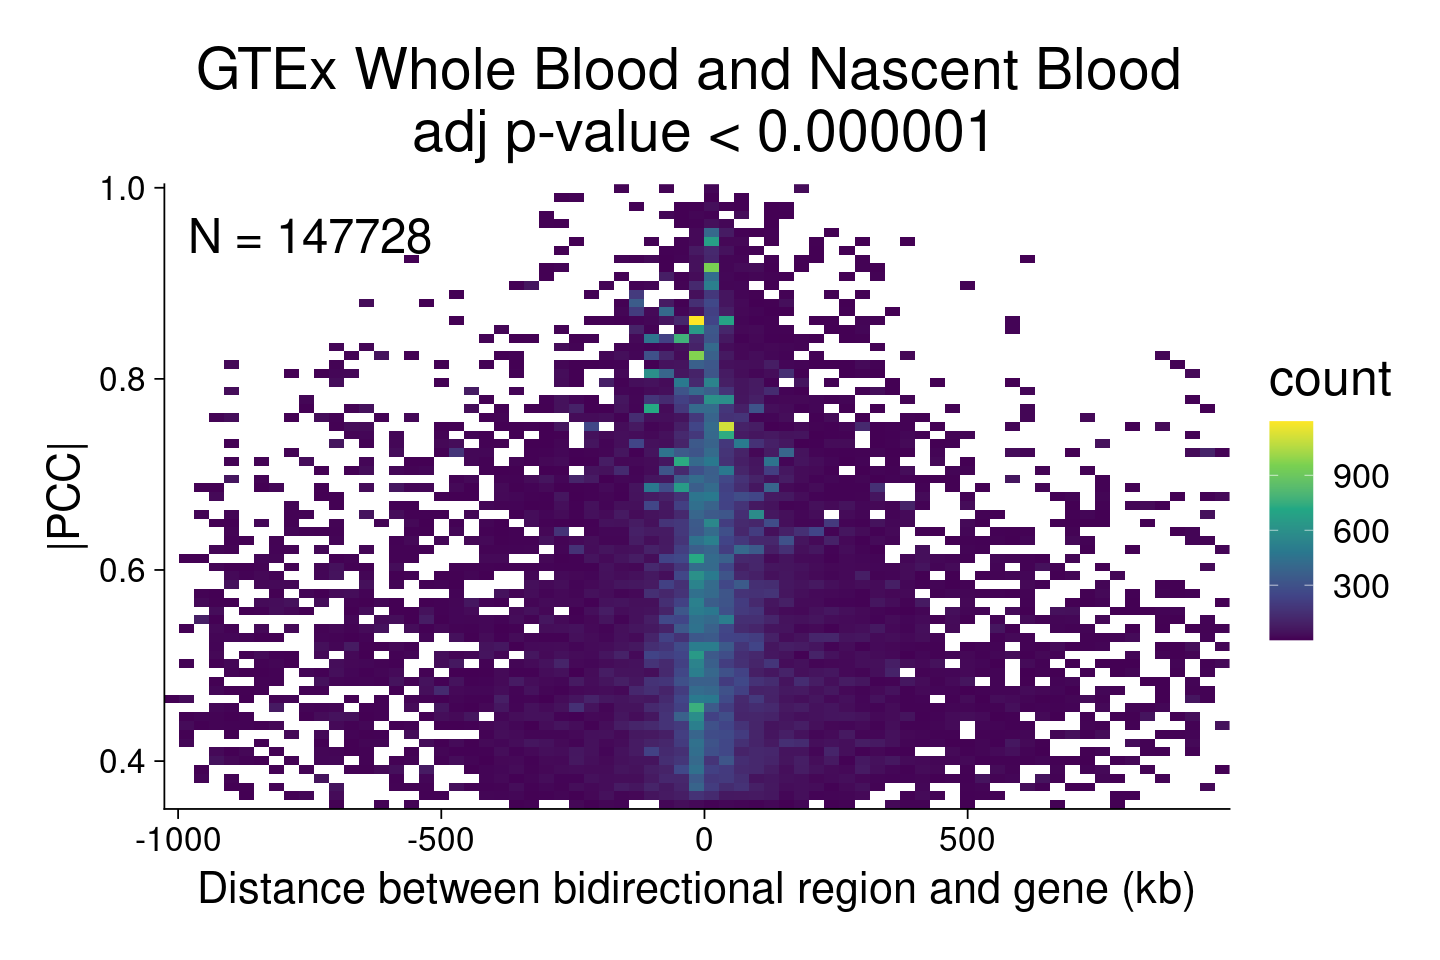

In [33]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist6 <- ggplot(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.000001)), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.000001)))),
         color="black") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.000001") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist6

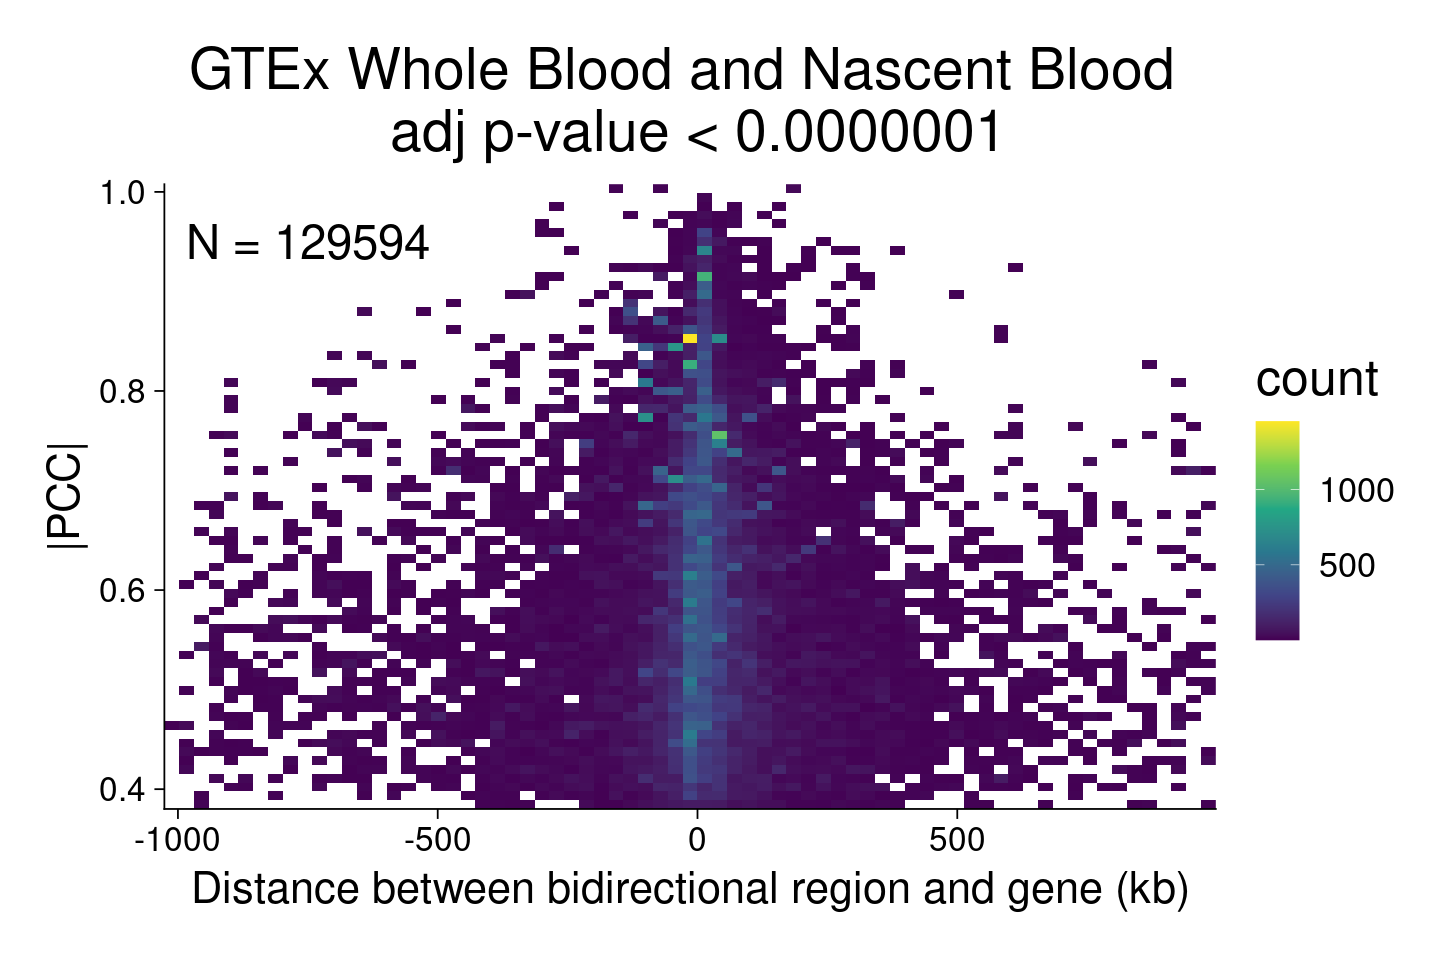

In [34]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist7 <- ggplot(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.0000001)), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.0000001)))),
         color="black") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.0000001") + #10-e7
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist7

In [35]:
options(repr.plot.width=32, repr.plot.height=16)

cowplot::plot_grid(blood_overlapping_gtex_dist2, 
                   blood_overlapping_gtex_dist3,
                   blood_overlapping_gtex_dist4,
                   blood_overlapping_gtex_dist5,
                   blood_overlapping_gtex_dist6,
                   blood_overlapping_gtex_dist7,
                   nrow=2)

### Explore adjusted p-values

In [108]:
pvalues <- c( 0.01, 0.0075, 0.005, 0.0025, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001,
             0.00000001,  0.000000001, 0.0000000001,  0.00000000001,
            0.000000000001, 0.0000000000001, 0.00000000000001) 

pvalues

[1] 1.0e-02 7.5e-03 5.0e-03 2.5e-03 1.0e-03 1.0e-04 1.0e-05 1.0e-06 1.0e-07
[10] 1.0e-08 1.0e-09 1.0e-10 1.0e-11 1.0e-12 1.0e-13 1.0e-14

In [109]:
number_eqtl_filt <- list()
number_pairs_filt <- list()

for (i in 1:length(pvalues)){
    
    #1. filter pairs by significance
    nascent_blood_filtered <- subset(nascent_blood, adj_p_BH < pvalues[i])
    
    #2. get overlaps
    overlap_pvals <- map_overlaps(overlap_DT = overlap_bed_DT,
                                  egene_ids = egene_files_DT_uniq, 
                                  nascent_pairs = nascent_blood_filtered)
    #3. save the overlaps
    number_eqtl_filt[[i]] <- overlap_pvals[[1]]
    number_pairs_filt[[i]] <- overlap_pvals[[2]]
}


In [110]:
pvalues_overlap_summary <- data.frame(adj_p_BH=pvalues,
                                   number_eqtl = as.numeric(number_eqtl_filt),
                                  number_pairs =  as.numeric(number_pairs_filt))
pvalues_overlap_summary$percent_eqtl = (pvalues_overlap_summary$number_eqtl/length(unique(gtex_blood$variant_id)))*100
pvalues_overlap_summary$percent_pairs = (pvalues_overlap_summary$number_pairs/length(unique(nascent_blood$pair_id)))*100
pvalues_overlap_summary

adj_p_BH number_eqtl number_pairs percent_eqtl percent_pairs
1  1.0e-02  62488       56050        4.892049     2.0528113    
2  7.5e-03  60283       54006        4.719424     1.9779505    
3  5.0e-03  57532       51450        4.504055     1.8843379    
4  2.5e-03  53533       47759        4.190982     1.7491564    
5  1.0e-03  49136       43676        3.846750     1.5996179    
6  1.0e-04  40968       35937        3.207295     1.3161798    
7  1.0e-05  35180       30510        2.754165     1.1174179    
8  1.0e-06  30948       26530        2.422851     0.9716518    
9  1.0e-07  27666       23366        2.165911     0.8557714    
10 1.0e-08  24900       20733        1.949367     0.7593387    
11 1.0e-09  22618       18578        1.770714     0.6804126    
12 1.0e-10  20622       16765        1.614451     0.6140121    
13 1.0e-11  18826       15157        1.473846     0.5551197    
14 1.0e-12  17365       13757        1.359468     0.5038452    
15 1.0e-13  16098       12545        1.260277     0.4594562    
16 1.0e-14  14863       11455        1.163592     0.4195353

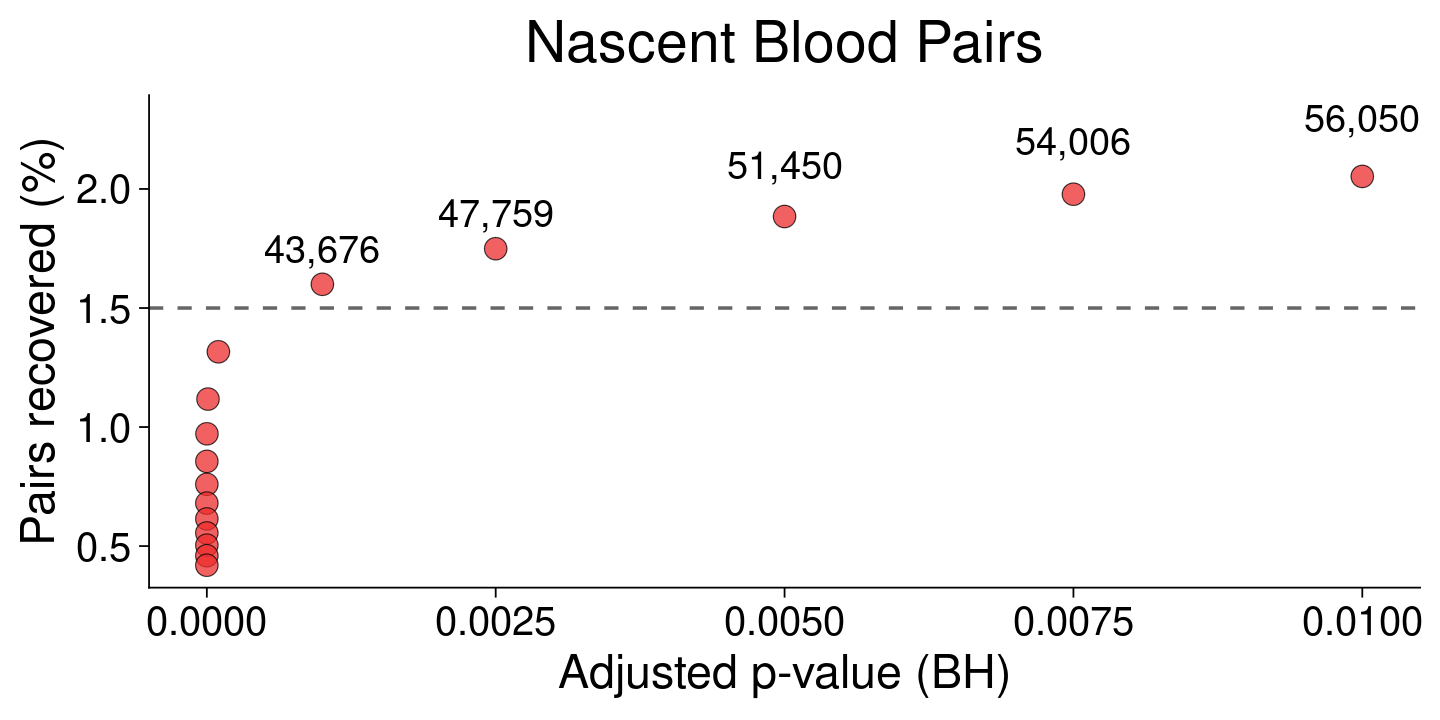

In [139]:
options(repr.plot.width=12, repr.plot.height=6)

pvalue_explore_plot <- ggplot(subset(pvalues_overlap_summary, adj_p_BH != 0.1), 
                       aes(x=adj_p_BH, 
                           y=percent_pairs)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=6, 
           fill='firebrick2',
          color='black') +
geom_hline(yintercept = 1.5,
           linetype="dashed", 
           color = "gray40", 
           size=1) +
annotate(geom="text", x=0.001, y=1.75, 
         size=8,
         label="43,676",
         color="black") +
annotate(geom="text", x=0.0025, y=1.9, 
         size=8,
         label="47,759",
         color="black") +
annotate(geom="text", x=0.005, y=2.1, 
         size=8,
         label="51,450",
         color="black") +
annotate(geom="text", x=0.0075, y=2.2, 
         size=8,
         label="54,006",
         color="black") +
annotate(geom="text", x=0.01, y=2.3, 
         size=8,
         label="56,050",
         color="black") +
ggtitle("Nascent Blood Pairs") +
ylab("Pairs recovered (%)") + 
xlab("Adjusted p-value (BH)") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

pvalue_explore_plot

### Exploring number of observations

In [130]:
nobs <- c(seq(3,222, 10), 221)
nobs 

[1]   3  13  23  33  43  53  63  73  83  93 103 113 123 133 143 153 163 173 183
[20] 193 203 213 221

In [132]:
max(nascent_blood$nObs)

[1] 222

In [133]:
number_eqtl_nobs <- list()
number_pairs_nobs <- list()

for (i in 1:length(nobs)){
    
    #1. filter pairs by significance
    nascent_blood_filtered <- subset(nascent_blood,
                                     adj_p_BH < 0.001 & 
                                     nObs >= nobs[i])
    
    #2. get overlaps
    overlap_nobs <- map_overlaps(overlap_DT = overlap_bed_DT,
                                  egene_ids = egene_files_DT_uniq, 
                                  nascent_pairs = nascent_blood_filtered)
    #3. save the overlaps
    number_eqtl_nobs[[i]] <- overlap_nobs[[1]]
    number_pairs_nobs[[i]] <- overlap_nobs[[2]]
}


In [135]:
nobs_overlap_summary <- data.frame(nobs=nobs,
                                   number_eqtl = as.numeric(number_eqtl_nobs),
                                  number_pairs =  as.numeric(number_pairs_nobs))
nobs_overlap_summary$percent_eqtl = (nobs_overlap_summary$number_eqtl/length(unique(gtex_blood$variant_id)))*100
nobs_overlap_summary$percent_pairs = (nobs_overlap_summary$number_pairs/length(unique(nascent_blood$pair_id)))*100
nobs_overlap_summary$percent_nobs <- (nobs_overlap_summary$nobs/max(nascent_blood$nObs))*100
nobs_overlap_summary

nobs number_eqtl number_pairs percent_eqtl percent_pairs percent_nobs
1    3  49136       43676        3.8467500    1.5996179      1.351351   
2   13  48781       43446        3.8189579    1.5911943      5.855856   
3   23  47892       42840        3.7493600    1.5689997     10.360360   
4   33  46427       41868        3.6346683    1.5334006     14.864865   
5   43  44512       40612        3.4847472    1.4874000     19.369369   
6   53  42691       39332        3.3421851    1.4405205     23.873874   
7   63  40669       37913        3.1838871    1.3885501     28.378378   
8   73  38805       36611        3.0379586    1.3408648     32.882883   
9   83  37107       35327        2.9050259    1.2938388     37.387387   
10  93  35561       34142        2.7839930    1.2504386     41.891892   
11 103  34042       32996        2.6650738    1.2084667     46.396396   
12 113  32511       31834        2.5452151    1.1659089     50.900901   
13 123  31037       30632        2.4298189    1.1218861     55.405405   
14 133  29638       29475        2.3202942    1.0795114     59.909910   
15 143  28212       28246        2.2086558    1.0344997     64.414414   
16 153  26787       27018        2.0970957    0.9895246     68.918919   
17 163  25128       25575        1.9672162    0.9366753     73.423423   
18 173  23523       24129        1.8415643    0.8837160     77.927928   
19 183  21712       22424        1.6997850    0.8212710     82.432432   
20 193  19518       20385        1.5280216    0.7465934     86.936937   
21 203  16697       17666        1.3071716    0.6470110     91.441441   
22 213  12304       13228        0.9632533    0.4844708     95.945946   
23 221   6399        7073        0.5009637    0.2590461     99.549550

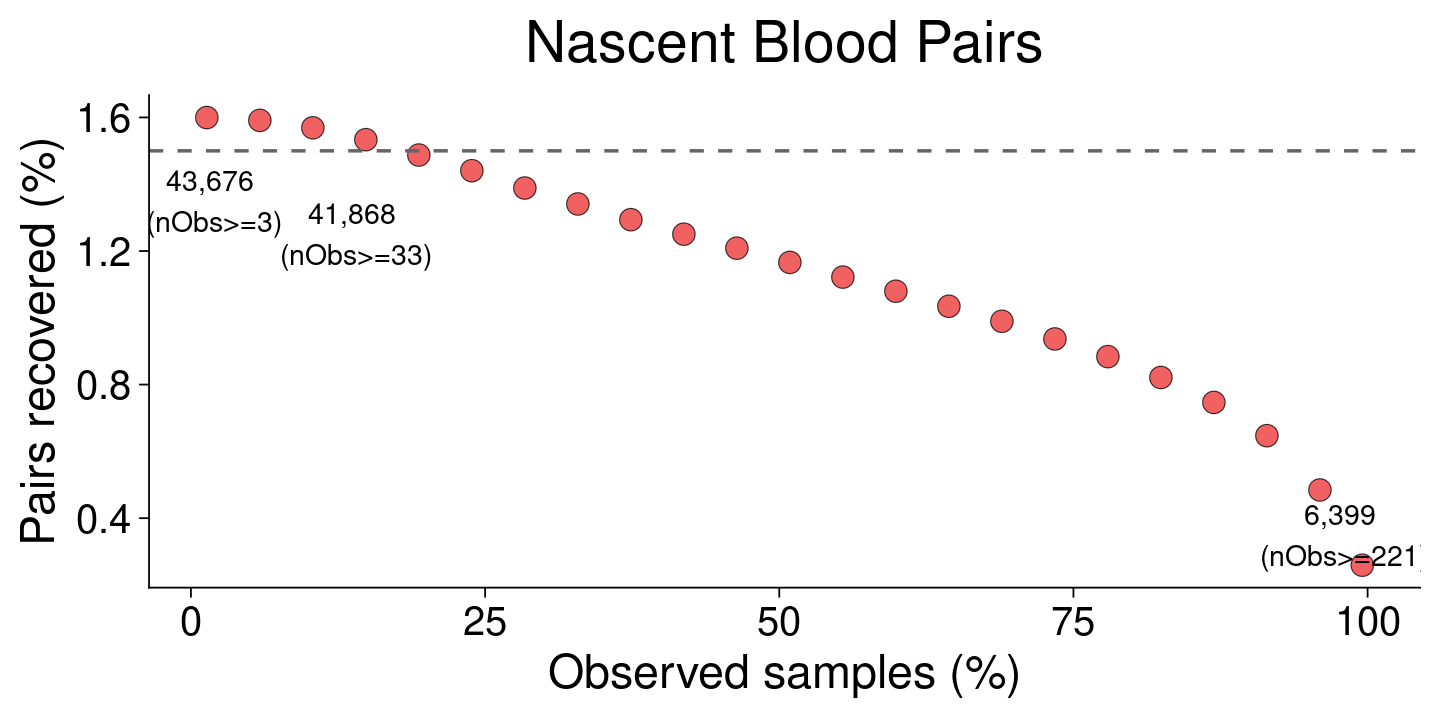

In [153]:
options(repr.plot.width=12, repr.plot.height=6)

nobs_explore_plot <- ggplot(nobs_overlap_summary, 
                       aes(x=percent_nobs, 
                           y=percent_pairs)) + 
geom_point(shape=21, 
           alpha=0.75, 
           size=6, 
           fill='firebrick2',
          color='black') +
geom_hline(yintercept = 1.5,
           linetype="dashed", 
           color = "gray40", 
           size=1) +
annotate(geom="text", x=2, y=1.35, 
         size=6,
         label="43,676 \n(nObs>=3)",
         color="black") +
annotate(geom="text", x=14, y=1.25, 
         size=6,
         label="41,868 \n(nObs>=33)",
         color="black") +
annotate(geom="text", x=98, y=0.35, 
         size=6,
         label="6,399 \n(nObs>=221)",
         color="black") +
ggtitle("Nascent Blood Pairs") +
ylab("Pairs recovered (%)") + 
xlab("Observed samples (%)") +
theme_cowplot(24) +
scale_y_continuous(labels = scales::comma) +
theme(plot.title = element_text(hjust = 0.5, face="plain"),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 24),
      axis.text.y = element_text(size = 24)) 

nobs_explore_plot

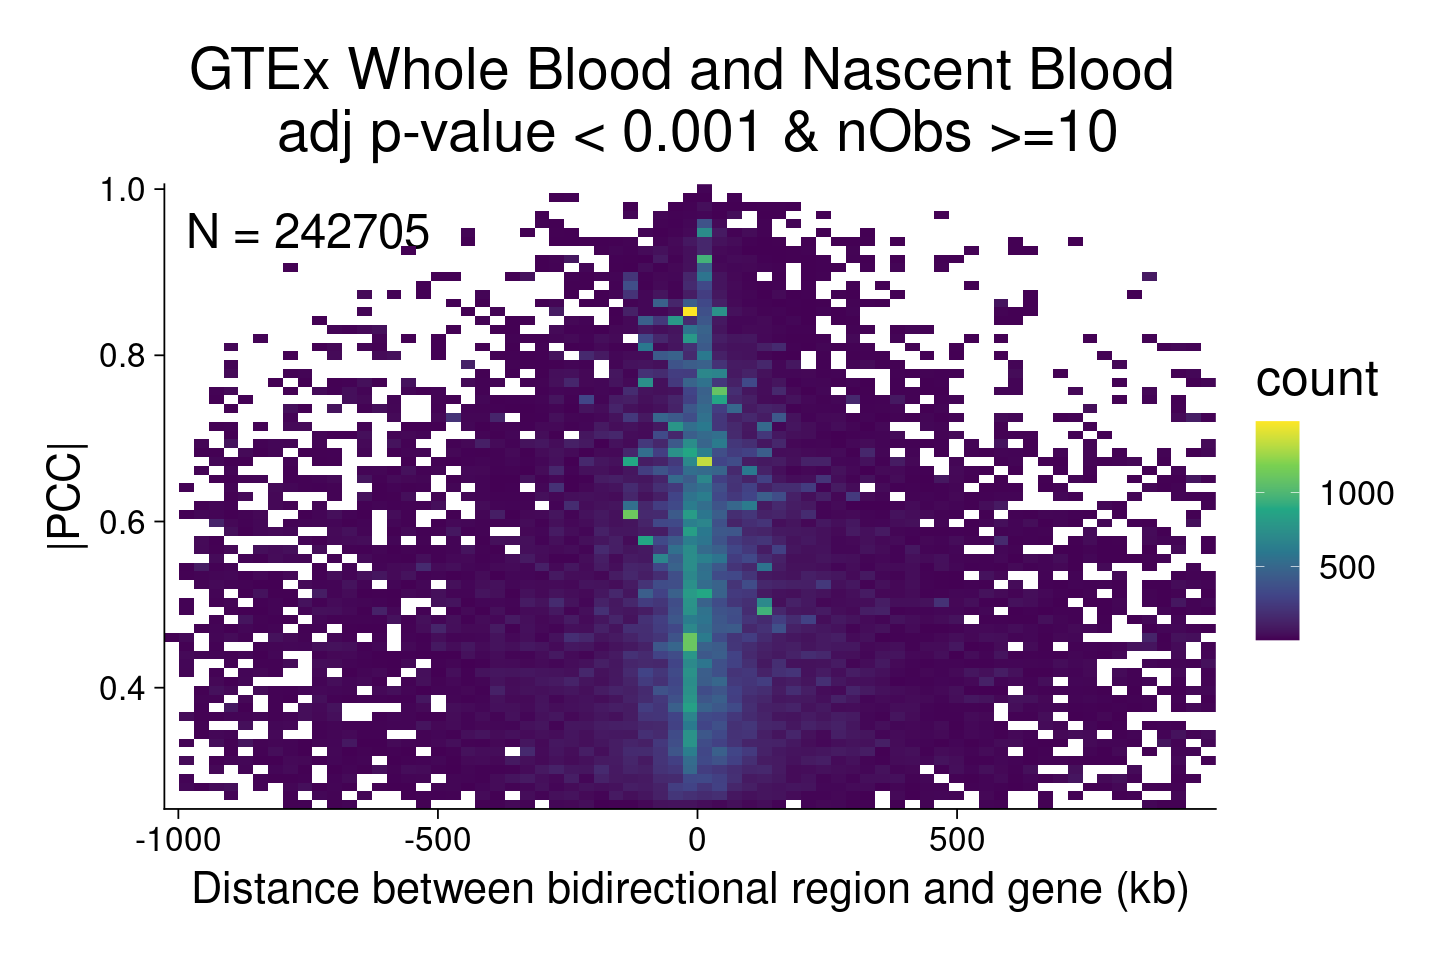

In [155]:
options(repr.plot.width=12, repr.plot.height=8)

blood_overlapping_gtex_dist_filt <- ggplot(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope','nObs',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.001 & nObs >=10)), 
       aes(x = distance_tss/1000, 
           y = abs(pcc))) + 
annotate(geom="text",
         x=-750, 
         y=0.95, 
         size=10,
         label=paste0("N = ",
                     nrow(unique(subset(overlap_bed_DT_nascent_gtex_blood[,
                                                                          c('variant_id','adj_p_BH','pcc',
                                                'pval_nominal_threshold','slope','nObs',
                                               'gene_name','transcript_1','distance_tss')], 
                                                    adj_p_BH < 0.001 & nObs >=10)))),
         color="black") +
geom_bin2d(bins = 70) +
  scale_fill_continuous(type = "viridis") +
theme_cowplot(24)+
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
ggtitle("GTEx Whole Blood and Nascent Blood \n adj p-value < 0.001 & nObs >=10") +
xlab("Distance between bidirectional region and gene (kb)") +
ylab("|PCC|") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 30), 
      axis.title = element_text(size = 26), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) +
theme(plot.margin = margin(1,1,1,1, "cm"))

blood_overlapping_gtex_dist_filt

# Compare overlap to random

## Function to shuffle genes

In [36]:
shuffle_genes <- function(pairs_DT, seed=42){
    ##shuffle genes within a chromosome pairs
    
    #set a seed
    set.seed(seed)
    
    #reassign the pairs to a new variable
    pairs_DT_shuffled_genes <- pairs_DT
    
    #shuffle the genes
    pairs_DT_shuffled_genes$transcript_1 <- sample(pairs_DT$transcript_1, 
                                                     nrow(pairs_DT)) 
    
    #relabel the gene names
    pairs_DT_shuffled_genes$nascent_gene_id <- as.character(lapply(strsplit(pairs_DT_shuffled_genes$transcript_1, ':'),
                                                      `[`, 1))
    return(pairs_DT_shuffled_genes)
   
}

In [37]:
dim(nascent_blood)
head(nascent_blood)

[1] 2730402      24

transcript1_chrom transcript1_start transcript1_stop transcript_1     
1 chr10             46887             48546            TUBB8:NM_177987.3
2 chr10             46887             48546            TUBB8:NM_177987.3
3 chr10             46887             48546            TUBB8:NM_177987.3
4 chr10             46887             48546            TUBB8:NM_177987.3
5 chr10             46887             48546            TUBB8:NM_177987.3
6 chr10             46887             48546            TUBB8:NM_177987.3
  transcript1_score transcript1_strand transcript2_chrom transcript2_start
1 .                 -                  chr10             749695           
2 .                 -                  chr10             969848           
3 .                 -                  chr10             972700           
4 .                 -                  chr10             976990           
5 .                 -                  chr10             978565           
6 .                 -                  chr10             986401           
  transcript2_stop transcript_2        ⋯ adj_p_BH     nObs t         
1 750013           chr10:749695-750013 ⋯ 0.0003002834  4   188.756638
2 970172           chr10:969848-970172 ⋯ 0.0026924465 40     3.935736
3 973240           chr10:972700-973240 ⋯ 0.0018123629 47     4.024305
4 977210           chr10:976990-977210 ⋯ 0.0065950765 44     3.547069
5 978731           chr10:978565-978731 ⋯ 0.0023978288 38     4.003165
6 986877           chr10:986401-986877 ⋯ 0.0002238290 48     4.750869
  distance_tss distance_tes position tissue percent_transcribed_both
1 -701308      -702967      upstream blood   1.801802               
2 -921464      -923123      upstream blood  18.018018               
3 -924424      -926083      upstream blood  21.171171               
4 -928554      -930213      upstream blood  19.819820               
5 -930102      -931761      upstream blood  17.117117               
6 -938093      -939752      upstream blood  21.621622               
  bidirectional_location pair_id                              
1 intergenic             TUBB8:NM_177987.3~chr10:749695-750013
2 intergenic             TUBB8:NM_177987.3~chr10:969848-970172
3 intergenic             TUBB8:NM_177987.3~chr10:972700-973240
4 intergenic             TUBB8:NM_177987.3~chr10:976990-977210
5 intergenic             TUBB8:NM_177987.3~chr10:978565-978731
6 intergenic             TUBB8:NM_177987.3~chr10:986401-986877

In [38]:
#1: split pairs by chromosomes
#This is allow for the gene shuffling to be done in a single chromosome

#get chromosomes
chroms <- unique(nascent_blood$transcript1_chrom)

#create an empty list for adding the data.tables
nascent_blood_chrom_list <- list()

#loop through and filter the chromosome pairs
for (i in chroms){

    nascent_blood_chrom_list[[i]] <- subset(nascent_blood,
                                          transcript1_chrom==i)
}

length(nascent_blood_chrom_list)

[1] 24

In [39]:
#2: Shuffle the pairs
nascent_blood_shuffle_list <- lapply(nascent_blood_chrom_list, shuffle_genes)
nascent_blood_shuffle <- do.call(rbind, nascent_blood_shuffle_list)
print(paste0("Number of shuffled pairs = ", nrow(nascent_blood_shuffle)))

[1] "Number of shuffled pairs = 2730402"


In [40]:
head(nascent_blood_shuffle)

transcript1_chrom transcript1_start transcript1_stop transcript_1            
1 chr10             46887             48546            CDK1:NM_001170407.2     
2 chr10             46887             48546            CFAP58:NM_001008723.2   
3 chr10             46887             48546            MYOZ1:NM_021245.4       
4 chr10             46887             48546            KCNMA1:NM_001271520.2   
5 chr10             46887             48546            MFSD13A:NM_024789.4     
6 chr10             46887             48546            LOC101928961:NR_111911.1
  transcript1_score transcript1_strand transcript2_chrom transcript2_start
1 .                 -                  chr10             749695           
2 .                 -                  chr10             969848           
3 .                 -                  chr10             972700           
4 .                 -                  chr10             976990           
5 .                 -                  chr10             978565           
6 .                 -                  chr10             986401           
  transcript2_stop transcript_2        ⋯ nObs t          distance_tss
1 750013           chr10:749695-750013 ⋯  4   188.756638 -701308     
2 970172           chr10:969848-970172 ⋯ 40     3.935736 -921464     
3 973240           chr10:972700-973240 ⋯ 47     4.024305 -924424     
4 977210           chr10:976990-977210 ⋯ 44     3.547069 -928554     
5 978731           chr10:978565-978731 ⋯ 38     4.003165 -930102     
6 986877           chr10:986401-986877 ⋯ 48     4.750869 -938093     
  distance_tes position tissue percent_transcribed_both bidirectional_location
1 -702967      upstream blood   1.801802                intergenic            
2 -923123      upstream blood  18.018018                intergenic            
3 -926083      upstream blood  21.171171                intergenic            
4 -930213      upstream blood  19.819820                intergenic            
5 -931761      upstream blood  17.117117                intergenic            
6 -939752      upstream blood  21.621622                intergenic            
  pair_id                               nascent_gene_id
1 TUBB8:NM_177987.3~chr10:749695-750013 CDK1           
2 TUBB8:NM_177987.3~chr10:969848-970172 CFAP58         
3 TUBB8:NM_177987.3~chr10:972700-973240 MYOZ1          
4 TUBB8:NM_177987.3~chr10:976990-977210 KCNMA1         
5 TUBB8:NM_177987.3~chr10:978565-978731 MFSD13A        
6 TUBB8:NM_177987.3~chr10:986401-986877 LOC101928961

In [41]:
#3: get only gene and bidirectional transcripts
nascent_blood_shuffle_pairs <- nascent_blood_shuffle[,c('transcript_1',
                                                   'transcript_2')]
nascent_blood_shuffle_pairs$gene_id <- as.character(lapply(strsplit(nascent_blood_shuffle_pairs$transcript_1, ':'),
                                                      `[`, 1))

head(nascent_blood_shuffle_pairs, 3)

transcript_1          transcript_2        gene_id
1 CDK1:NM_001170407.2   chr10:749695-750013 CDK1   
2 CFAP58:NM_001008723.2 chr10:969848-970172 CFAP58 
3 MYOZ1:NM_021245.4     chr10:972700-973240 MYOZ1

In [42]:
overlap_bed_DT_genename_bidirs_shuffle <- merge(overlap_bed_DT_genename,
                                        nascent_blood_shuffle,
                                       by.x='bidir_id',
                                       by.y='transcript_2',
                                       all = TRUE, 
                                        allow.cartesian=TRUE)
dim(overlap_bed_DT_genename_bidirs_shuffle)
head(overlap_bed_DT_genename_bidirs_shuffle, 2)

[1] 5776335      38

bidir_id                  gene_id            chr_variant start_variant
1 chr10:100000773-100001115 NA                 NA                 NA    
2 chr10:100001829-100002093 ENSG00000196072.11 chr10       100002037    
  end_variant ref_variant alt_variant ref chr_bidir start_bidir ⋯ nObs t       
1        NA   NA          NA          NA  NA               NA   ⋯ 23   5.317216
2 100002038   G           A           b38 chr10     100001829   ⋯ 10   4.747783
  distance_tss distance_tes position   tissue percent_transcribed_both
1 -735201      -746493      upstream   blood  10.360360               
2  268978       245827      downstream blood   4.504505               
  bidirectional_location pair_id                                      
1 intragenic             PAX2:NM_001374303.1~chr10:100000773-100001115
2 intragenic             CUTC:NM_015960.3~chr10:100001829-100002093   
  nascent_gene_id
1 GBF1           
2 SH2D4B

In [43]:
overlap_bed_DT_genename_bidirs_shuffle$nascent_gene_id <- as.character(lapply(strsplit(overlap_bed_DT_genename_bidirs_shuffle$transcript_1, ':'),
                                                      `[`, 1))

In [44]:
##overlaps will have complete cases
#overlap_bed_DT_genename_bidirs_shuffle_complete <- overlap_bed_DT_genename_bidirs_shuffle[complete.cases(overlap_bed_DT_genename_bidirs_shuffle),]
#dim(overlap_bed_DT_genename_bidirs_shuffle_complete)
#head(overlap_bed_DT_genename_bidirs_shuffle_complete, 2)

In [45]:
#overlap_bed_DT_genename_bidirs_shuffle_complete$nascent_gene_id <- as.character(lapply(strsplit(overlap_bed_DT_genename_bidirs_shuffle_complete$transcript_1, ':'),
#                                                      `[`, 1))

In [46]:
#colnames(overlap_bed_DT_genename_bidirs_shuffle)

In [47]:
nrow(subset(overlap_bed_DT_genename_bidirs_shuffle, gene_name==nascent_gene_id))

[1] 4381

In [49]:
overlap_bed_DT_nascent_shuffle_gtex <- subset(overlap_bed_DT_genename_bidirs_shuffle,
                                     gene_name==nascent_gene_id)
dim(overlap_bed_DT_nascent_shuffle_gtex)
head(overlap_bed_DT_nascent_shuffle_gtex)

[1] 4381   38

bidir_id                  gene_id            chr_variant start_variant
1 chr10:100209660-100210020 ENSG00000196072.11 chr10       100209892    
2 chr10:100461256-100461904 ENSG00000075826.16 chr10       100461437    
3 chr10:100461256-100461904 ENSG00000075826.16 chr10       100461666    
4 chr10:100487153-100487651 ENSG00000166135.13 chr10       100487650    
5 chr10:101594735-101595177 ENSG00000166189.7  chr10       101594991    
6 chr10:101703170-101703430 ENSG00000166189.7  chr10       101703224    
  end_variant ref_variant alt_variant ref chr_bidir start_bidir ⋯ nObs t       
1 100209893   C           A           b38 chr10     100209660   ⋯  80  3.529385
2 100461438   A           G           b38 chr10     100461256   ⋯ 114  5.055090
3 100461667   G           A           b38 chr10     100461256   ⋯ 114  5.055090
4 100487651   C           A           b38 chr10     100487153   ⋯ 212  3.389767
5 101594992   G           A           b38 chr10     101594735   ⋯ 140  4.106133
6 101703225   G           A           b38 chr10     101703170   ⋯ 194  6.194631
  distance_tss distance_tes position   tissue percent_transcribed_both
1 -296498      -334270      upstream   blood  36.03604                
2 -194692      -229283      upstream   blood  51.35135                
3 -194692      -229283      upstream   blood  51.35135                
4 -574060      -611832      upstream   blood  95.49550                
5  417885       400809      downstream blood  63.06306                
6  410952       403188      downstream blood  87.38739                
  bidirectional_location pair_id                                        
1 intragenic             DNMBP:NM_001318327.1~chr10:100209660-100210020 
2 intergenic             CWF19L1:NM_018294.6~chr10:100461256-100461904  
3 intergenic             CWF19L1:NM_018294.6~chr10:100461256-100461904  
4 intragenic             DNMBP:NM_001318327.1~chr10:100487153-100487651 
5 intragenic             LINC01514:NR_120620.1~chr10:101594735-101595177
6 intergenic             LDB1:NM_003893.5~chr10:101703170-101703430     
  nascent_gene_id
1 BLOC1S2        
2 SEC31B         
3 SEC31B         
4 HIF1AN         
5 HPS6           
6 HPS6

In [50]:
length(unique(overlap_bed_DT_nascent_gtex$pair_id))
length(unique(overlap_bed_DT_nascent_shuffle_gtex$pair_id))

[1] 56050

[1] 2719

In [51]:
length(unique(overlap_bed_DT_nascent_gtex$variant_id))
length(unique(overlap_bed_DT_nascent_shuffle_gtex$variant_id))

[1] 62488

[1] 3934

## Function to get overlaps

In [52]:
map_overlaps <- function(overlap_DT, egene_ids, nascent_pairs){
    
    #1: merge the GTEx overlaps with gene ids
    overlap_bed_DT_genename <- merge(overlap_DT, 
                                     egene_ids,
                                     by='gene_id')
    
    #2: merge the overlap bed file with the nascent pairs
    overlap_bed_DT_genename_bidirs <- merge(overlap_bed_DT_genename,
                                            nascent_pairs,
                                            by.x = 'bidir_id',
                                            by.y = 'transcript_2',
                                            all = TRUE, 
                                            allow.cartesian=TRUE) ##for duplicate keys

    #3: get overlapping bidirectionals and match gene pairs
    overlap_bed_DT_nascent_gtex <- subset(overlap_bed_DT_genename_bidirs,
                                          gene_name==nascent_gene_id)
    
    #4: summarize overlaps
    overlaps <- list(length(unique(overlap_bed_DT_nascent_gtex$variant_id)),
                    length(unique(overlap_bed_DT_nascent_gtex$pair_id)))

    return(overlaps)
    
}

### Process overlaps

In [53]:
number_eqtl <- list()
number_pairs <- list()
seed_values <- 1:20

for (i in 1:20){
    
    #1. shuffle the pairs
    nascent_blood_shuffle_list <- mclapply(nascent_blood_chrom_list, 
                                           shuffle_genes, 
                                           seed=i,  
                                           mc.cores = 10)
    
    nascent_blood_shuffle <- do.call(rbind, nascent_blood_shuffle_list)
    
    #2. get overlaps 
    overlap_shuffle <- map_overlaps(overlap_DT = overlap_bed_DT,
                                    egene_ids = egene_files_DT_uniq, 
                                    nascent_pairs = nascent_blood_shuffle)
    
    #3. save the overlaps
    number_eqtl[[i]] <- overlap_shuffle[[1]]
    number_pairs[[i]] <- overlap_shuffle[[2]]
    
}

In [73]:
seed_values <- 1:20
seed_values

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

In [74]:
shuffle_pair_summary <- data.frame(seed_value=seed_values,
                                   number_eqtl = as.numeric(number_eqtl),
                                  number_pairs =  as.numeric(number_pairs))
shuffle_pair_summary$percent_eqtl = (shuffle_pair_summary$number_eqtl/length(unique(gtex_blood$variant_id)))*100
shuffle_pair_summary$percent_pairs = (shuffle_pair_summary$number_pairs/length(unique(nascent_blood$pair_id)))*100
shuffle_pair_summary

seed_value number_eqtl number_pairs percent_eqtl percent_pairs
1   1         3739        2699         0.2927181    0.09884991   
2   2         3679        2614         0.2880209    0.09573682   
3   3         3930        2693         0.3076711    0.09863017   
4   4         3897        2707         0.3050876    0.09914291   
5   5         3883        2718         0.3039916    0.09954578   
6   6         3783        2648         0.2961628    0.09698206   
7   7         3686        2626         0.2885689    0.09617631   
8   8         3756        2670         0.2940490    0.09778780   
9   9         3780        2658         0.2959279    0.09734830   
10 10         3802        2720         0.2976503    0.09961903   
11 11         3908        2633         0.3059488    0.09643269   
12 12         3737        2645         0.2925616    0.09687218   
13 13         3929        2743         0.3075928    0.10046140   
14 14         4040        2767         0.3162828    0.10134039   
15 15         3809        2654         0.2981983    0.09720180   
16 16         3857        2760         0.3019561    0.10108402   
17 17         3973        2668         0.3110375    0.09771455   
18 18         3967        2798         0.3105678    0.10247575   
19 19         3749        2622         0.2935010    0.09602982   
20 20         3931        2726         0.3077494    0.09983878

### Test parallel

#### shuffle

In [44]:
start.time0 <- Sys.time()

nascent_blood_lapply <- lapply(nascent_blood_chrom_list, 
                                           shuffle_genes, 
                                           seed=42)

end.time0 <- Sys.time()
time.taken0 <- end.time0 - start.time0
time.taken0

Time difference of 6.133768 secs

In [45]:
start.time <- Sys.time()
nascent_blood_mclapply <- mclapply(nascent_blood_chrom_list, 
                                           shuffle_genes, 
                                           seed=42,  
                                           mc.cores = 10)

end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

Time difference of 5.404046 secs

#### As a function

In [ ]:
shuffle_genes_iteration <- function(loops=20){

    number_eqtl <- list()
    number_pairs <- list()
    seed_values <- 1:loops

    for (i in 1:loops){

        #1. shuffle the pairs
        nascent_blood_shuffle_list <- lapply(nascent_blood_chrom_list, 
                                               shuffle_genes, 
                                               seed=i)

        nascent_blood_shuffle <- do.call(rbind, nascent_blood_shuffle_list)

        #2. get overlaps 
        overlap_shuffle <- map_overlaps(overlap_DT = overlap_bed_DT,
                                        egene_ids = egene_files_DT_uniq, 
                                        nascent_pairs = nascent_blood_shuffle)

        #3. save the overlaps
        number_eqtl[[i]] <- overlap_shuffle[[1]]
        number_pairs[[i]] <- overlap_shuffle[[2]]

    }
    
    shuffle_pair_summary <- data.frame(seed_value=seed_values,
                                   number_eqtl = as.numeric(number_eqtl),
                                  number_pairs =  as.numeric(number_pairs))
    shuffle_pair_summary$percent_eqtl = (shuffle_pair_summary$number_eqtl/length(unique(gtex_blood$variant_id)))*100
    shuffle_pair_summary$percent_pairs = (shuffle_pair_summary$number_pairs/length(unique(nascent_blood$pair_id)))*100
    
    return(shuffle_pair_summary)
}

In [48]:
shuffled_overlaps <- function(seed_val=42, chrom_list, overlap_bed, egene_DT_uniq){

        #1. shuffle the pairs using updated seed
        nascent_shuffle_list <- lapply(chrom_list, 
                                       shuffle_genes, 
                                       seed_val)

        nascent_shuffle <- do.call(rbind, nascent_shuffle_list)

        #2. get overlaps of shuffled pairs  
        overlap_shuffle <- map_overlaps(overlap_DT = overlap_bed,
                                        egene_ids = egene_DT_uniq, 
                                        nascent_pairs = nascent_shuffle)

        #3. save the overlaps
        return(overlap_shuffle)
        
}

In [49]:
#seeds <- 1:20
start.time1 <- Sys.time()

shuffled_overlaps_fxn <- shuffled_overlaps(chrom_list=nascent_blood_chrom_list,
                              overlap_bed=overlap_bed_DT,
                              egene_DT_uniq=egene_files_DT_uniq,
                              seed_val=1)

end.time1 <- Sys.time()
time.taken1 <- end.time1 - start.time1
time.taken1

Time difference of 13.41396 secs

In [51]:
shuffled_overlaps_fxn

$eqtl_overlap
[1] 3739

$nascent_pair_overlap
[1] 2699

In [64]:
start.time2 <- Sys.time()
seeds_list <- c(1:5)
shuffled_overlaps_lapply <- lapply(seeds_list,
                                shuffled_overlaps,
                                chrom_list=nascent_blood_chrom_list,
                              overlap_bed=overlap_bed_DT,
                              egene_DT_uniq=egene_files_DT_uniq)

end.time2 <- Sys.time()
time.taken2 <- end.time2 - start.time2
time.taken2

Time difference of 1.075703 mins

In [65]:
shuffled_overlaps_lapply

[[1]]
[[1]]$eqtl_overlap
[1] 3739

[[1]]$nascent_pair_overlap
[1] 2699


[[2]]
[[2]]$eqtl_overlap
[1] 3679

[[2]]$nascent_pair_overlap
[1] 2614


[[3]]
[[3]]$eqtl_overlap
[1] 3930

[[3]]$nascent_pair_overlap
[1] 2693


[[4]]
[[4]]$eqtl_overlap
[1] 3897

[[4]]$nascent_pair_overlap
[1] 2707


[[5]]
[[5]]$eqtl_overlap
[1] 3883

[[5]]$nascent_pair_overlap
[1] 2718

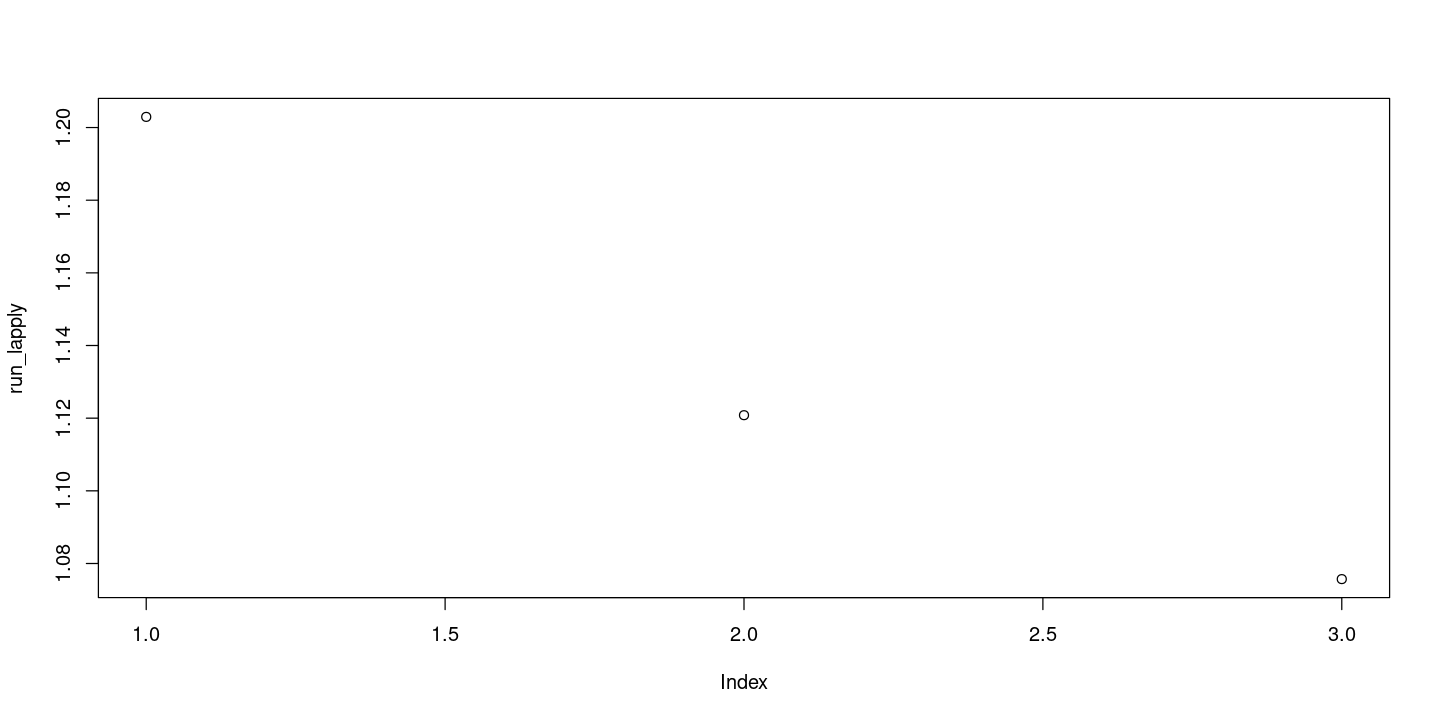

In [66]:
run_lapply <- c(1.202932,1.120824, 1.075703)
plot(run_lapply)

In [77]:
pryr::mem_change(lapply(seeds_list,
       shuffled_overlaps,
       chrom_list=nascent_blood_chrom_list,
       overlap_bed=overlap_bed_DT,
       egene_DT_uniq=egene_files_DT_uniq))

1.86 MB

In [78]:
start.time3 <- Sys.time()
seeds_list <- c(1:5)
shuffled_overlaps_mclapply <- mclapply(seeds_list,
                                shuffled_overlaps,
                                chrom_list=nascent_blood_chrom_list,
                              overlap_bed=overlap_bed_DT,
                              egene_DT_uniq=egene_files_DT_uniq,
                                      mc.cores = 5)

end.time3 <- Sys.time()
time.taken3 <- end.time3 - start.time3
time.taken3

Time difference of 13.61129 secs

In [80]:
shuffled_overlaps_mclapply

[[1]]
[[1]]$eqtl_overlap
[1] 3739

[[1]]$nascent_pair_overlap
[1] 2699


[[2]]
[[2]]$eqtl_overlap
[1] 3679

[[2]]$nascent_pair_overlap
[1] 2614


[[3]]
[[3]]$eqtl_overlap
[1] 3930

[[3]]$nascent_pair_overlap
[1] 2693


[[4]]
[[4]]$eqtl_overlap
[1] 3897

[[4]]$nascent_pair_overlap
[1] 2707


[[5]]
[[5]]$eqtl_overlap
[1] 3883

[[5]]$nascent_pair_overlap
[1] 2718

In [ ]:
shuffle_pair_summary <- data.frame(seed_value=seed_values,
                                   number_eqtl = as.numeric(number_eqtl),
                                  number_pairs =  as.numeric(number_pairs))
shuffle_pair_summary$percent_eqtl = (shuffle_pair_summary$number_eqtl/length(unique(gtex_blood$variant_id)))*100
shuffle_pair_summary$percent_pairs = (shuffle_pair_summary$number_pairs/length(unique(nascent_blood$pair_id)))*100
shuffle_pair_summary

In [89]:
shuffle_pair_summary <- as.data.table(t(as.data.table(shuffled_overlaps_mclapply)))
colnames(shuffle_pair_summary) <- c("number_eqtl","number_pairs")
shuffle_pair_summary$percent_eqtl = (as.numeric(shuffle_pair_summary$number_eqtl)/length(unique(gtex_blood$variant_id)))*100
shuffle_pair_summary$percent_pairs = (as.numeric(shuffle_pair_summary$number_pairs)/length(unique(nascent_blood$pair_id)))*100
shuffle_pair_summary$seed_value <- seeds_list

shuffle_pair_summary

number_eqtl number_pairs percent_eqtl percent_pairs seed_value
1 3739        2699         0.2927181    0.09884991    1         
2 3679        2614         0.2880209    0.09573682    2         
3 3930        2693         0.3076711    0.09863017    3         
4 3897        2707         0.3050876    0.09914291    4         
5 3883        2718         0.3039916    0.09954578    5

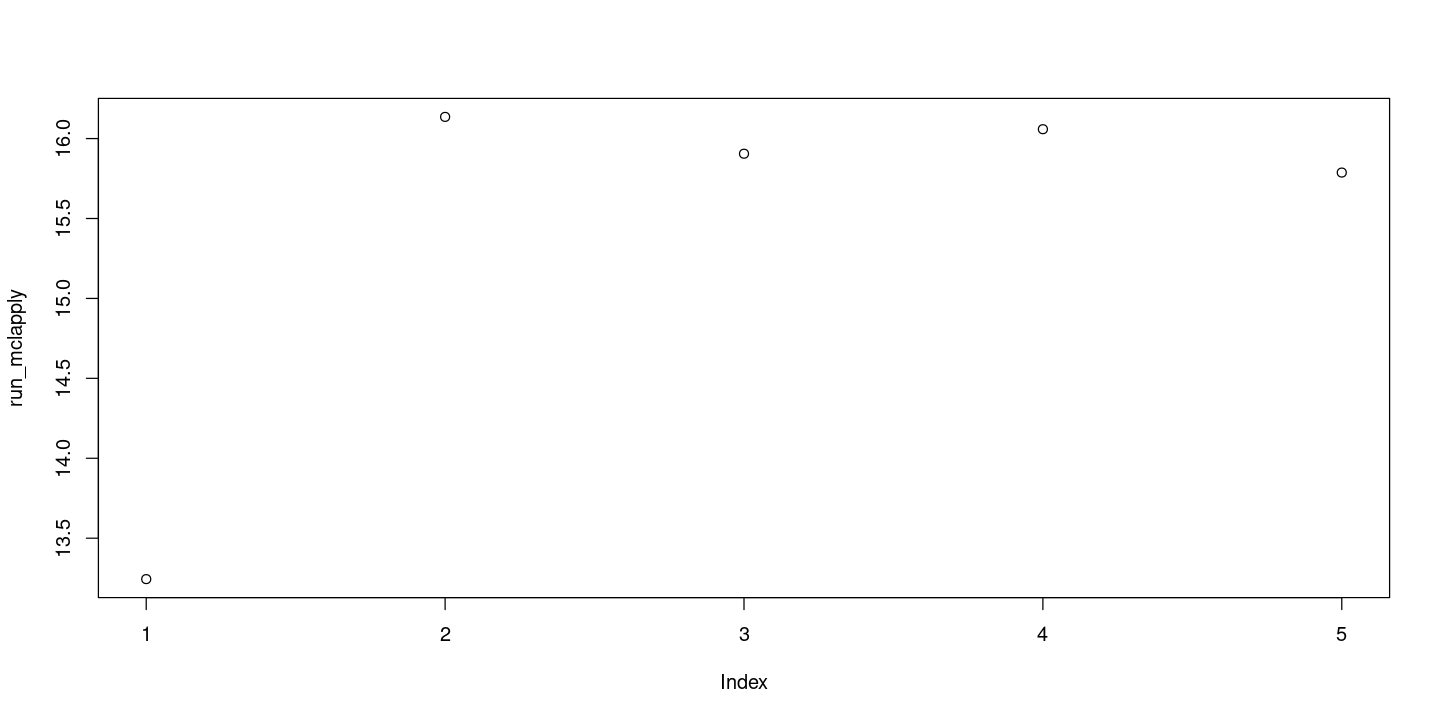

In [71]:
run_mclapply <- c(13.24405, 16.13554, 15.90511, 16.05854, 15.78735)

plot(run_mclapply)

In [74]:
mean(run_mclapply)
mean(run_lapply)

[1] 15.42612

[1] 1.133153

In [72]:
(mean(run_mclapply)*5)/60

[1] 1.28551

In [79]:
pryr::mem_change(mclapply(seeds_list,
         shuffled_overlaps,
         chrom_list=nascent_blood_chrom_list,
         overlap_bed=overlap_bed_DT,
         egene_DT_uniq=egene_files_DT_uniq,
         mc.cores = 5))

-1.55 kB

### Plot overlaps

In [55]:
percent_recovered_transcribed <- length(unique(overlap_bed_DT_nascent_gtex_blood$pair_id))/nrow(nascent_blood)*100
percent_recovered_transcribed

[1] 2.052811

In [56]:
hist(shuffle_pair_summary$percent_pairs)

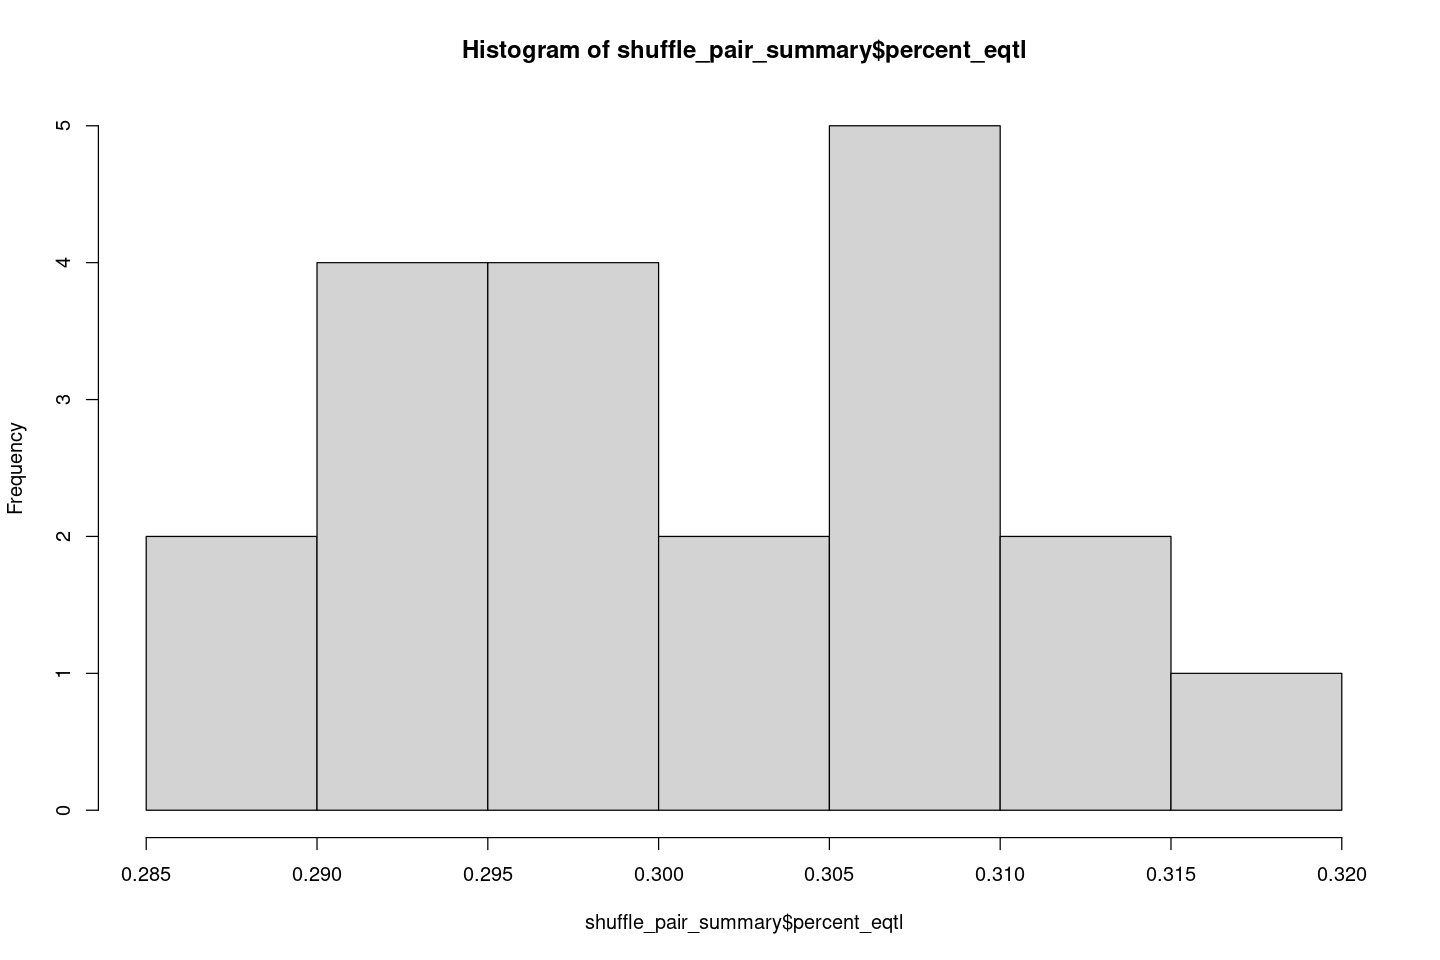

In [184]:
hist(shuffle_pair_summary$percent_eqtl)

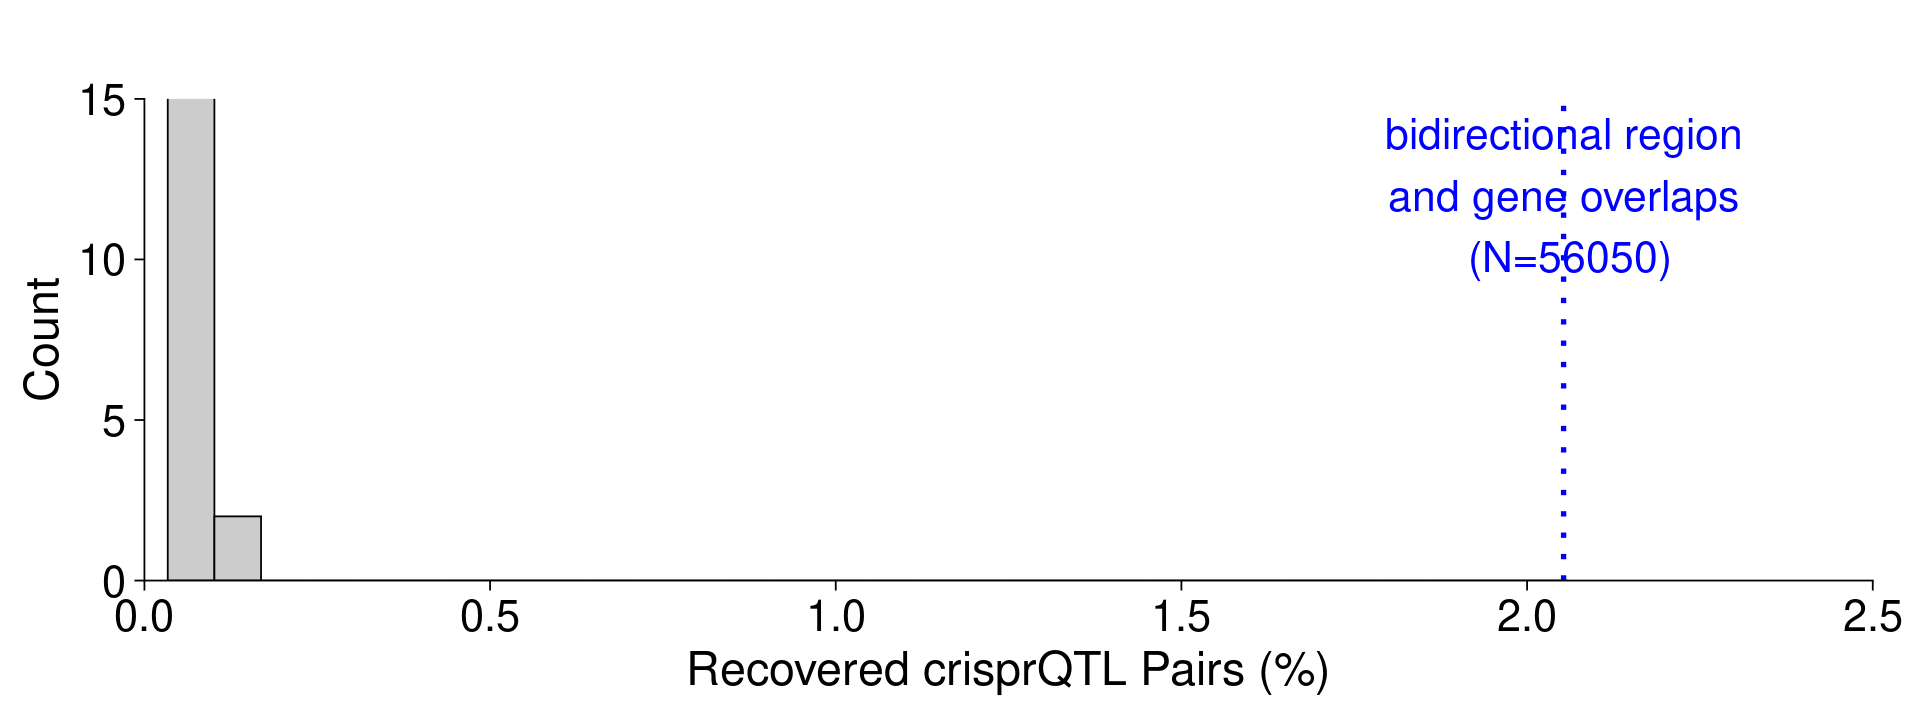

In [68]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotB <- ggplot(shuffle_pair_summary, aes(x=percent_pairs)) + 
geom_histogram(color="black", fill="gray80", bins = 30) +
geom_vline(xintercept = percent_recovered_transcribed,
           linetype="dotted", 
                color = "blue", size=1.5) +
annotate(geom="text", size=9,
         x=percent_recovered_transcribed,
         y=12, 
         label=paste0("bidirectional region\n and gene overlaps \n (N=",
                     length(unique(overlap_bed_DT_nascent_gtex_blood$pair_id)),")"),
         color="blue") +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(xlim=c(0,2.5), ylim=c(0,15)) +
theme_cowplot(24) +
  labs(title = " ", 
       y = "Count",
       x = "Recovered crisprQTL Pairs (%)") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))


overlap_plotB

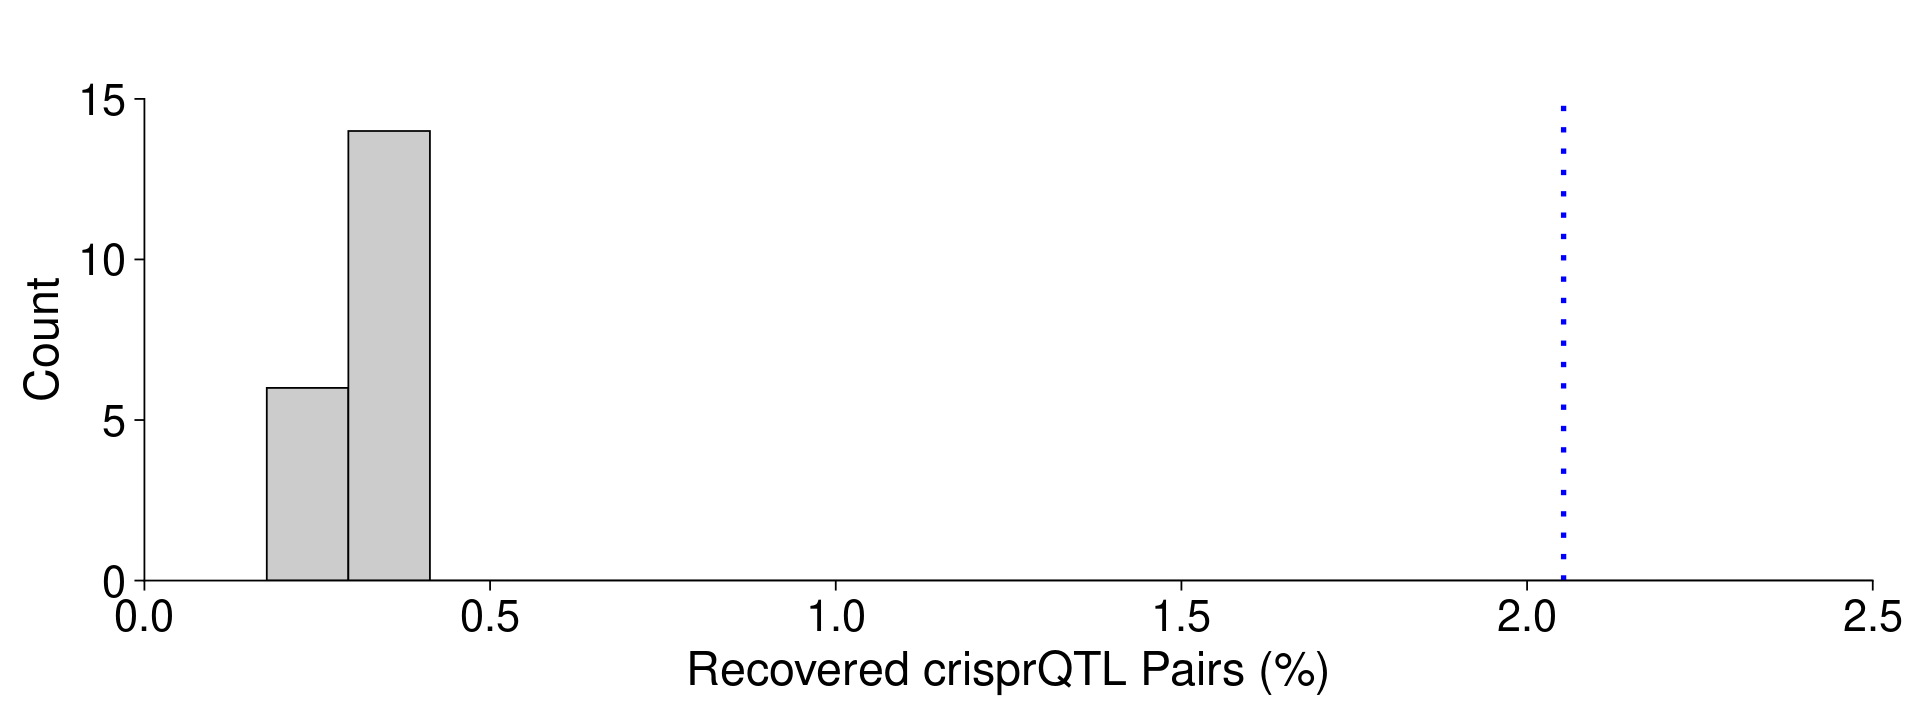

In [188]:
options(repr.plot.width=16, repr.plot.height=6)

overlap_plotB <- ggplot(shuffle_pair_summary, aes(x=percent_eqtl)) + 
geom_histogram(color="black", fill="gray80", bins = 30) +
geom_vline(xintercept = percent_recovered_transcribed,
           linetype="dotted", 
                color = "blue", size=1.5) +
annotate(geom="text", size=9,
         x=nrow(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','gene_id.x')]))/nrow(gtex_blood)*100,
         y=12, 
         label=paste0("bidirectional region\n and gene overlaps \n (N=",
                     length(unique(overlap_bed_DT_nascent_gtex_blood$pair_id)),")"),
         color="blue") +
scale_x_continuous(expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(xlim=c(0,2.5), ylim=c(0,15)) +
theme_cowplot(24) +
  labs(title = " ", 
       y = "Count",
       x = "Recovered crisprQTL Pairs (%)") +
theme(plot.title = element_text(hjust = 0.5),
      title = element_text(size = 30), 
      axis.title = element_text(size = 28), 
      axis.text = element_text(size = 26)) +
theme(plot.margin = margin(0.5,1,0.5,0.5, "cm"))


overlap_plotB

In [69]:
#https://rdrr.io/github/ghurault/HuraultMisc/src/R/pval.R

empirical_pval <- function(t_rep, t, alternative = c("two.sided", "less", "greater")) {
    
    #default will be set to "two.sided" if none are supplied
    alternative <- match.arg(alternative)
    
    #variables for p-value calulcations
    #number of permutations greater than observed
    r <- sum(t_rep > t)
    
    #total number of permutations
    n <- length(t_rep)
    
    #empirical p-value where r is the number of permutation tests with
    #a “more extreme” observed test statistic  Tithan  T0
    p <- (r + 1) / (n + 1) # instead of r/n, since the r replicates and the data are assumed from the null
    
    if (alternative == "greater") {
        
        pval <- p
        
    } else if (alternative == "less") {
        
        pval <- 1 - p
        
    } else if (alternative == "two.sided") {
        
        pval <- 2 * min(p, 1 - p)
    }
    
    return(pval)
}

In [189]:
empirical_pval(as.numeric(shuffle_pair_summary$percent_pairs),
               nrow(unique(overlap_bed_DT_nascent_gtex_blood[,c('variant_id','gene_id.x')]))/nrow(gtex_blood)*100, 
                    alternative = "greater")

[1] 0.04761905

In [159]:
1/1000

[1] 0.001

# Example pipeline

# Session Information

In [88]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/libopenblasp-r0.3.3.so;  LAPACK version 3.8.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/Denver
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.3     dplyr_1.1.4       ggplot2_3.5.1     data.table_1.15.4

loaded via a namespace (and not attached):
 [1] crayon_1.5.2      vctrs_0.6.5       cli_3.6.2         rlang_1.1.4      
 [5] generics_0.1.3    jsonlite_1.8.8    labeling_0.4.3    glue_1.